In [1]:
import os
import similaritymeasures
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.neighbors import DistanceMetric
import seaborn as sns
from scipy.spatial import minkowski_distance

import pandas as pd

In [3]:
def nDTW(exp_data,num_data,d_th=1,p=2):
    r"""
    Parameters
    ----------
    exp_data: list
        experimental trajectory
    num_data: list
        reference trajectory
    d_th: float
        threshold distance for task completion
    p : float, 1 <= p <= infinity
        Which Minkowski p-norm to use. Default is p=2 (Eculidean).
        The manhattan distance is p=1.        
    Returns
    -------
    ndtw : float
        normalized dynamic time warping distance
    """
    dtw = np.ones((len(exp_data)+1,len(num_data)+1))*np.inf
    dtw[0,0] = 0
    for i in range(1,len(exp_data)+1):
        for j in range(1,len(num_data)+1):
            cost = minkowski_distance(exp_data[i],num_data[j])
            dtw[i,j] = cost+np.min([dtw[i-1,j],dtw[i,j-1],dtw[i-1,j-1]])
    DTW = dtw[len(exp_data),len(num_data)]
    ndtw = np.exp(-DTW/(len(num_data)*d_th))
    return ndtw

In [4]:
def TC(exp_data,num_data,d_th=3,p=2):
    r"""
    Parameters
    ----------
    exp_data: list
        experimental trajectory
    num_data: list
        reference trajectory
    d_th: float [default = 3 (meters)]
        threshold distance for task completion
    p : float, 1 <= p <= infinity
        Which Minkowski p-norm to use. Default is p=2 (Eculidean).
        The manhattan distance is p=1.        
    Returns
    -------
    tc : bool
        Task Completion score
    """
    return (exp_data[-1]-num_data[-1])<=d_th
    

In [5]:
def ade_matching(exp_data, num_data, p=2):
    r"""
    Compute the ADE by using matching used in Discrete Frechet Distance
    Compute the ADE between two N-D curves according to matching in
    [1]_. The Frechet distance has been defined as the walking dog problem.
    From Wikipedia: "In mathematics, the Frechet distance is a measure of
    similarity between curves that takes into account the location and
    ordering of the points along the curves. It is named after Maurice Frechet.
    https://en.wikipedia.org/wiki/Fr%C3%A9chet_distance
    Parameters
    ----------
    exp_data : array_like
        Curve from your experimental data. exp_data is of (M, N) shape, where
        M is the number of data points, and N is the number of dimmensions
    num_data : array_like
        Curve from your numerical data. num_data is of (P, N) shape, where P
        is the number of data points, and N is the number of dimmensions
    p : float, 1 <= p <= infinity
        Which Minkowski p-norm to use. Default is p=2 (Eculidean).
        The manhattan distance is p=1.
    Returns
    -------
    df : float
        discrete Frechet distance
    References
    ----------
    .. [1] Thomas Eiter and Heikki Mannila. Computing discrete Frechet
        distance. Technical report, 1994.
        http://www.kr.tuwien.ac.at/staff/eiter/et-archive/cdtr9464.pdf
        http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.90.937&rep=rep1&type=pdf
    """
    n = len(exp_data)
    m = len(num_data)
    ca = np.ones((n, m))
    ca = np.multiply(ca, -1)
    ca[0, 0] = minkowski_distance(exp_data[0], num_data[0], p=p)
    for i in range(1, n):
        ca[i, 0] = ca[i-1, 0]+ minkowski_distance(exp_data[i], num_data[0],
                                                      p=p)
    for j in range(1, m):
        ca[0, j] = ca[0, j-1]+ minkowski_distance(exp_data[0], num_data[j],
                                                      p=p)
    for i in range(1, n):
        for j in range(1, m):
            ca[i, j] = min(ca[i-1, j], ca[i, j-1], ca[i-1, j-1])+minkowski_distance(exp_data[i], num_data[j], p=p)
    return ca[n-1, m-1]/max(n,m)



In [6]:
def get_commands(val_path):
    commands = []
    for episode in os.listdir(val_path):
        filename = os.path.join(val_path,episode,'command.txt')
        with open(filename,'r') as f:
            command = f.readline().strip()
            commands.append(command)
    return commands

In [7]:
def get_scores(val_data_path, val_run_path, save_loc, episodes = None,subplots = False):
    os.makedirs(save_loc,exist_ok=True)
    frechet_dists = []
    fde_dists = []
    ade_dists = []
    ade_match_dists = []
    if episodes is None:
        episodes = list(range(50))
    if subplots != False:
        fig = plt.figure(figsize=(10,5))
        handles = []
        labels = []
    for i,episode in enumerate(episodes):
        if subplots != False:
            plt.subplot(subplots[i])
            print('subplotting')
        else:
            plt.figure(figsize=(10,10))
        episode = str(episode)
        filename = os.path.join(val_run_path,episode,'vehicle_positions.txt')
        with open(filename,'r') as f:
            positions = f.readlines()
        run_traj = np.array([ [ float(t.strip()) for t in x.strip().split(',')] for x in positions])

        filename = os.path.join(val_data_path,episode,'vehicle_positions.txt')
        with open(filename,'r') as f:
            positions = f.readlines()
        data_traj = np.array([ [ float(t.strip()) for t in x.strip().split(',')] for x in positions])

        filename = os.path.join(val_run_path,episode,'command.txt')
        with open(filename,'r') as f:
            command = f.readline().strip()

        plt.plot(data_traj[:,0],data_traj[:,1],label='Ground Truth')
        plt.plot(run_traj[:,0],run_traj[:,1],label='Inference on Prediction')
        plt.scatter(data_traj[-1,0],data_traj[-1,1],s=100,label='Ground Truth - End Point')
        plt.scatter(run_traj[-1,0],run_traj[-1,1],s=100,label='Inference - End Point')
        plt.scatter(data_traj[0,0],data_traj[0,1],s=100,label='Starting Point')

        x_min = np.min(np.hstack([data_traj[:,0],run_traj[:,0]]))
        y_min = np.min(np.hstack([data_traj[:,1],run_traj[:,1]]))

        x_max = np.max(np.hstack([data_traj[:,0],run_traj[:,0]]))
        y_max = np.max(np.hstack([data_traj[:,1],run_traj[:,1]]))

        frechet_dists.append(similaritymeasures.frechet_dist(run_traj,data_traj))
        
        min_length = min(run_traj.shape[0],data_traj.shape[0])
        
        r_idx = np.arange(1,run_traj.shape[0]-1)
        np.random.shuffle(r_idx)
        r_idx = [0]+r_idx[:min_length-2].tolist()+[run_traj.shape[0]-1]
        r_idx = sorted(r_idx)
        run_traj_trimmed = run_traj[r_idx]

        d_idx = np.arange(1,data_traj.shape[0]-1)
        np.random.shuffle(d_idx)
        d_idx = [0]+d_idx[:min_length-2].tolist()+[data_traj.shape[0]-1]
        d_idx = sorted(d_idx)
        data_traj_trimmed = data_traj[d_idx]
        print(data_traj_trimmed.shape,run_traj_trimmed.shape)
        
        distances = np.sqrt(np.sum((data_traj_trimmed-run_traj_trimmed)**2,axis=1))
        ade = np.sum(distances)/min_length
        ade_dists.append(ade)
        
        ade_match_dists.append(ade_matching(run_traj,data_traj))


        fde_dists.append(similaritymeasures.distance.euclidean(data_traj[-1,:],run_traj[-1,:]))
        
        size = max(x_max-x_min+10,y_max-y_min+10)
        if x_max-x_min>y_max-y_min:
            excess_size = size-(y_max-y_min)
            excess_size/=2
            plt.xlim(x_min-5, x_max+5)
            plt.ylim(y_min-excess_size, y_max+excess_size)
        else:
            excess_size = size-(x_max-x_min)
            excess_size/=2
            plt.xlim(x_min-excess_size, x_max+excess_size)
            plt.ylim(y_min-5, y_max+5)
        plt.gca().invert_xaxis()
        plt.gca().set_aspect('equal')
        plt.axis('off')
        plt.title(command)

#         plt.legend()
        if subplots == False:
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=2)
            plt.savefig(os.path.join(save_loc,episode)+'.png') 
        
        print(f'Episode {episode}: {command}')
        print(f'Frechet Distance: {frechet_dists[-1]}')
        print(f'FDE Distance: {fde_dists[-1]}')
        print(f'ADE Distance: {ade_dists[-1]}')
        print(f'ADE Matched Distance: {ade_match_dists[-1]}')
    #     print(f'Curve Length Measure: {cl_measures[-1]}')
        if subplots == False:
            plt.show()
    if subplots != False:
        lines_labels = [ ax.get_legend_handles_labels() for ax in fig.axes]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        lines = lines[:5]
        labels = labels[:5]
#         fig.legend(lines, labels)
        
        print(lines,labels)
        
        fig.legend(lines,labels,loc='upper center', bbox_to_anchor=(0.5, 0.15),
          fancybox=True, shadow=True, ncol=2)
        plt.savefig(os.path.join(save_loc,'final')+'.png') 
        plt.show()
        
    return frechet_dists, fde_dists, ade_dists, ade_match_dists

In [8]:
# ! scp varunc@ada:/share3/varunc/val_runs.zip /ssd_scratch/cvit/varunc
# ! unzip /ssd_scratch/cvit/varunc/val_runs.zip
# ! scp varunc@ada:/share3/varunc/val_run_baseline.zip /ssd_scratch/cvit/varunc
# ! unzip /ssd_scratch/cvit/varunc/val_run_baseline.zip
# ! scp varunc@ada:/share3/varunc/val_convlstm.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_framebyframe.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_fbf2.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_temp_convattn.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_run_fbf_network2.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_dual2_fbf_mask.zip /ssd_scratch/cvit/varunc
# unzip /ssd_scratch/cvit/varunc/val_convlstm.zip

scp varunc@ada:/share3/varunc/val_runs.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_runs.zip
scp varunc@ada:/share3/varunc/val_run_baseline.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_run_baseline.zip
scp varunc@ada:/share3/varunc/val_convlstm.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_convlstm.zip
scp varunc@ada:/share3/varunc/val_framebyframe.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_framebyframe.zip
scp varunc@ada:/share3/varunc/val_fbf2.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_fbf2.zip
scp varunc@ada:/share3/varunc/val_temp_convattn.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_temp_convattn.zip
scp varunc@ada:/share3/varunc/val_run_fbf_network2.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_run_fbf_network2.zip

scp varunc@ada:/share3/varunc/val_dual_fgf_mask.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_dual_fgf_mask.zip
scp varunc@ada:/share3/varunc/val_dual_fgf_trajectory.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_dual_fgf_trajectory.zip


(553, 3) (553, 3)
Episode 0: Turn left and stop next to the bus stop.
Frechet Distance: 43.51258063853686
FDE Distance: 43.51258063853686
ADE Distance: 4.99048543030981
ADE Matched Distance: 2.603935706518025


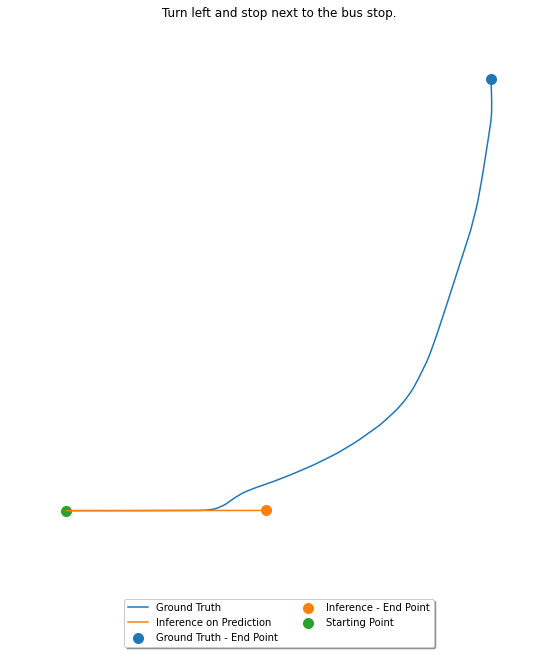

(94, 3) (94, 3)
Episode 1: Take a left from the interection.
Frechet Distance: 18.67360239961607
FDE Distance: 18.67360239961607
ADE Distance: 9.199027536763445
ADE Matched Distance: 2.531467686538739


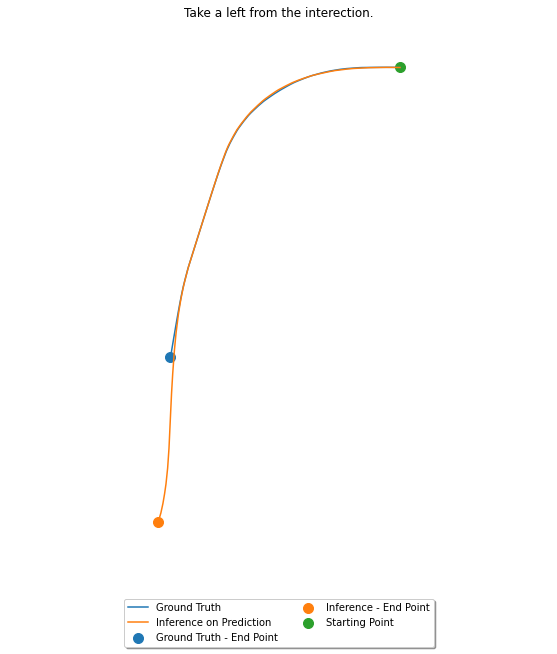

(55, 3) (55, 3)
Episode 2: Drive straight till you see a red coloured board
Frechet Distance: 0.6554414195607362
FDE Distance: 0.6554414195607362
ADE Distance: 1.376735496298318
ADE Matched Distance: 0.10121567370919969


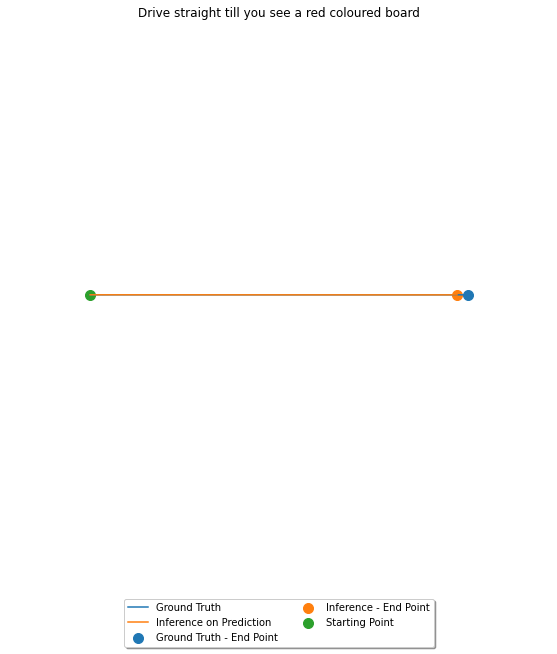

(38, 3) (38, 3)
Episode 3: Park just ahead of the speed signboard
Frechet Distance: 17.453272761888233
FDE Distance: 17.453272761888233
ADE Distance: 6.039872255033124
ADE Matched Distance: 3.852188690567769


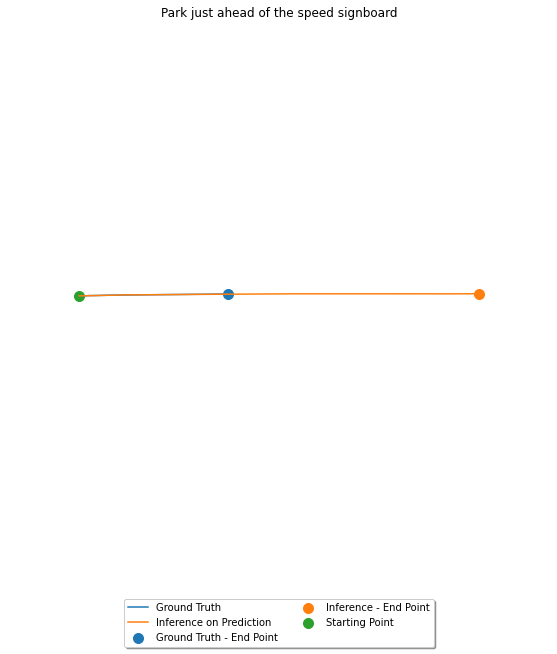

(332, 3) (332, 3)
Episode 4: Take the next right turn.
Frechet Distance: 5.6088478491112195
FDE Distance: 5.6088478491112195
ADE Distance: 8.367360699061324
ADE Matched Distance: 1.3806664020817714


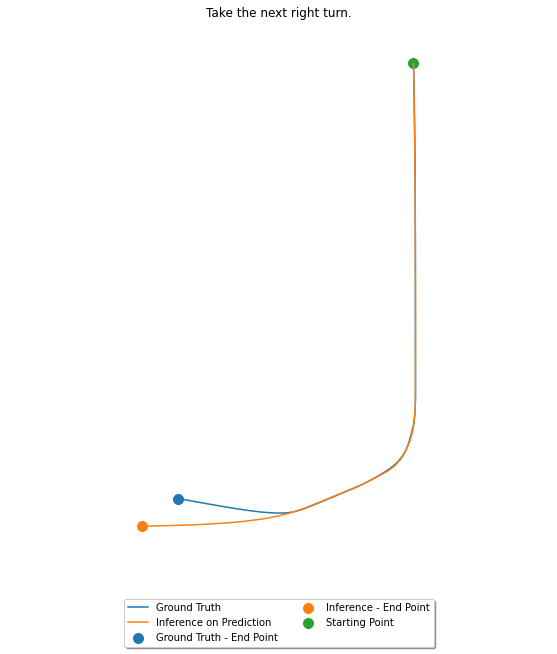

(150, 3) (150, 3)
Episode 5: Drive straight from the next crossroads.
Frechet Distance: 4.476293873391282
FDE Distance: 4.476293873391282
ADE Distance: 3.437699527046907
ADE Matched Distance: 0.4674502938660115


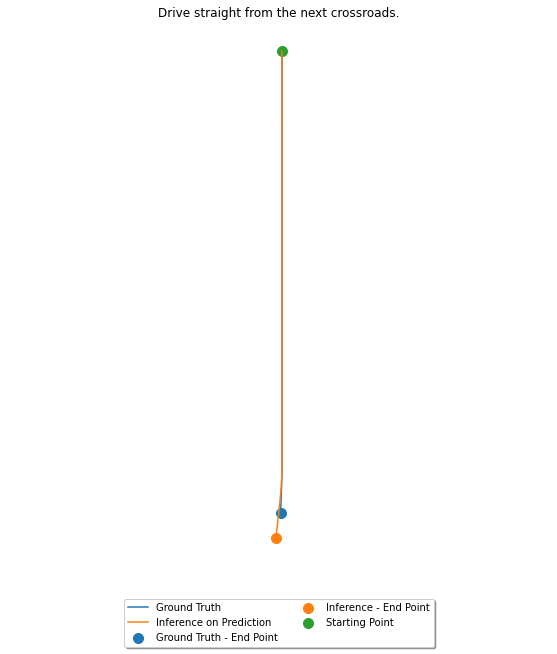

(70, 3) (70, 3)
Episode 6: change to left lane
Frechet Distance: 26.44121240187925
FDE Distance: 26.44121240187925
ADE Distance: 12.290610592223526
ADE Matched Distance: 7.227682048008699


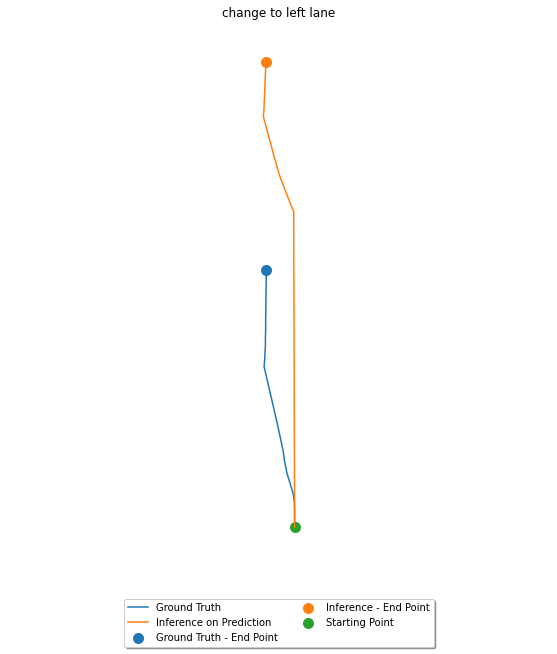

(42, 3) (42, 3)
Episode 7: Stop near the scooty
Frechet Distance: 29.32097266160802
FDE Distance: 29.320972661608025
ADE Distance: 9.59327201821965
ADE Matched Distance: 6.625894214429435


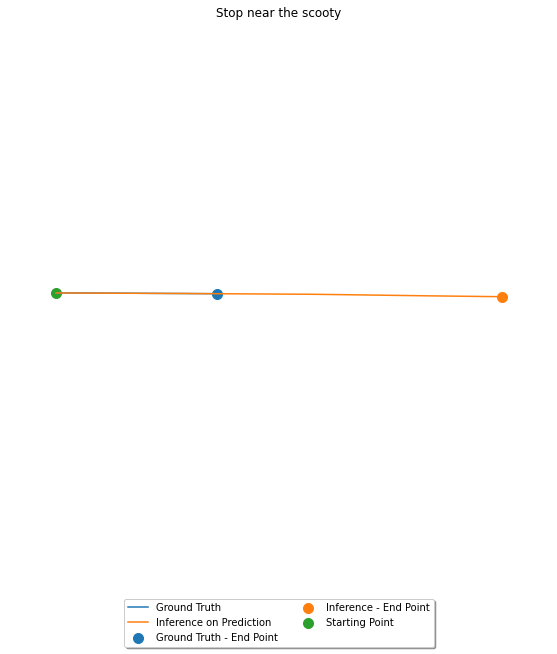

(142, 3) (142, 3)
Episode 8: take right and stop near the speed limit sign
Frechet Distance: 11.533171609885391
FDE Distance: 11.533171609885391
ADE Distance: 10.547900240545326
ADE Matched Distance: 4.956718344166312


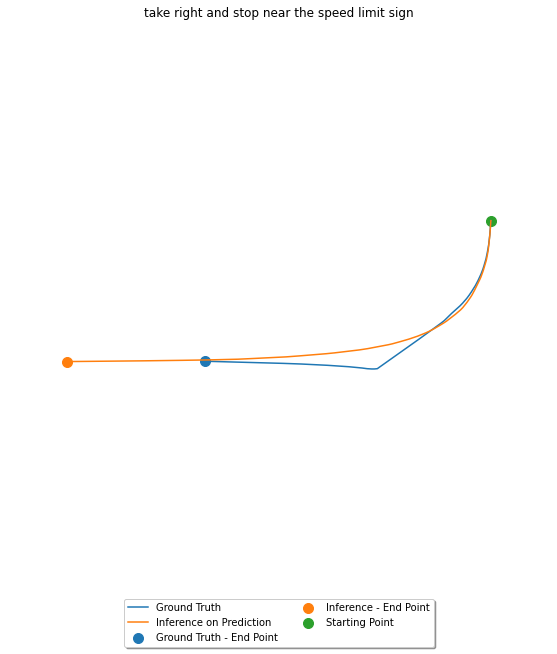

(59, 3) (59, 3)
Episode 9: Turn right and stop near the bus stop.
Frechet Distance: 0.9356895743980193
FDE Distance: 0.9124500717986177
ADE Distance: 1.8367416008942523
ADE Matched Distance: 0.26676932504254924


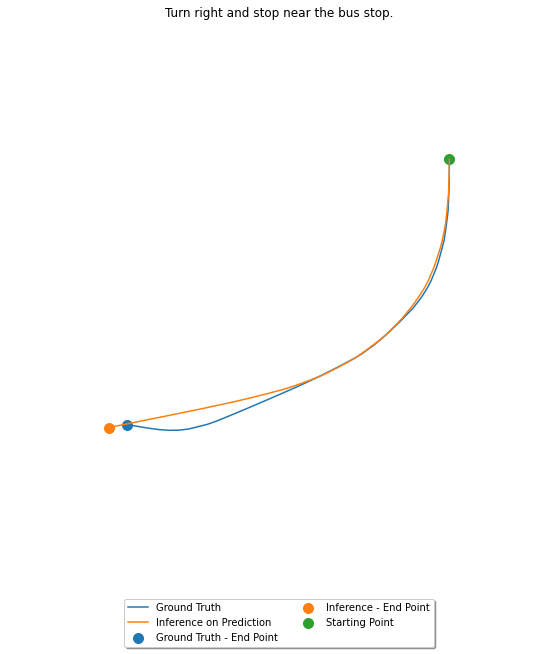

(66, 3) (66, 3)
Episode 10: Shift to the left lane and stop at the intersection.
Frechet Distance: 6.331183820929018
FDE Distance: 6.331183820929018
ADE Distance: 3.8184212391877828
ADE Matched Distance: 2.1852877880296706


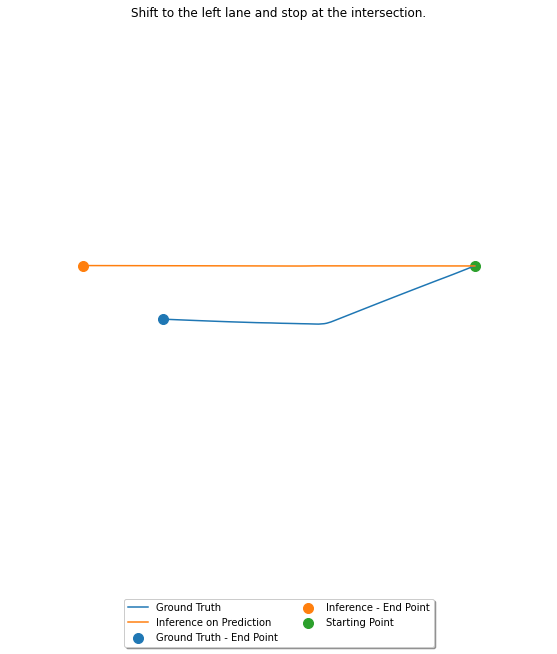

(45, 3) (45, 3)
Episode 11: Stop after crossing the stop signboard
Frechet Distance: 4.292999998566482
FDE Distance: 4.292999998566482
ADE Distance: 1.9995100711879739
ADE Matched Distance: 0.32901731512846294


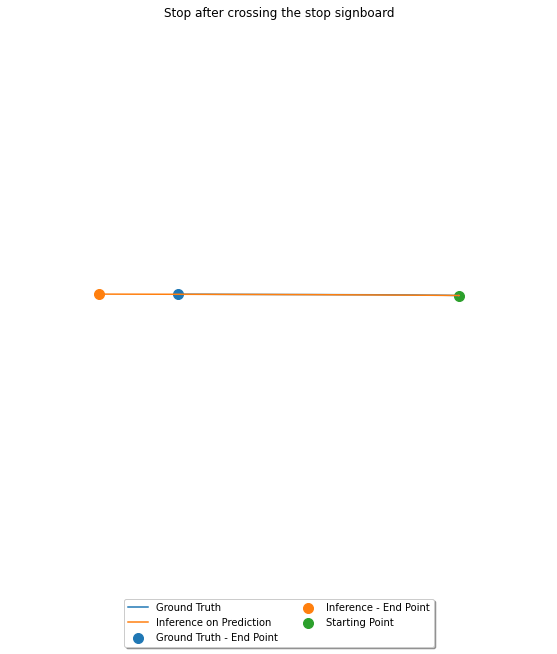

(45, 3) (45, 3)
Episode 12: Park near the red signboard
Frechet Distance: 5.247926855469539
FDE Distance: 5.247926855469539
ADE Distance: 2.7126302034402325
ADE Matched Distance: 0.37448867354581633


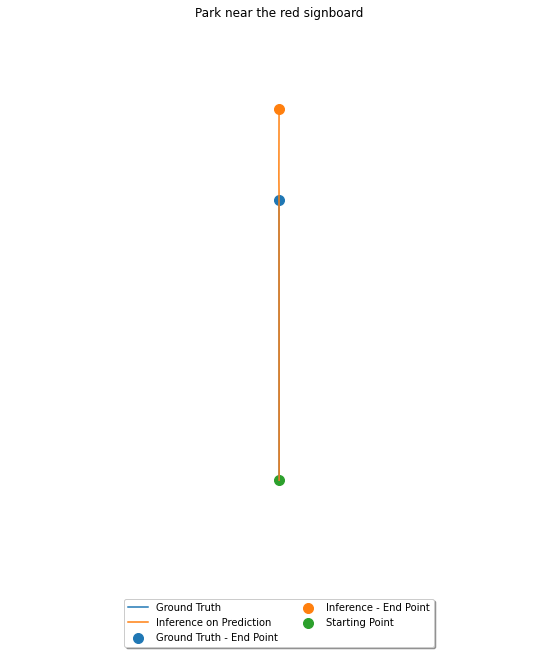

(340, 3) (340, 3)
Episode 13: Wait at the traffic light then go straight.
Frechet Distance: 52.01984067694993
FDE Distance: 52.01984067694993
ADE Distance: 13.375729314488584
ADE Matched Distance: 2.6410938628552523


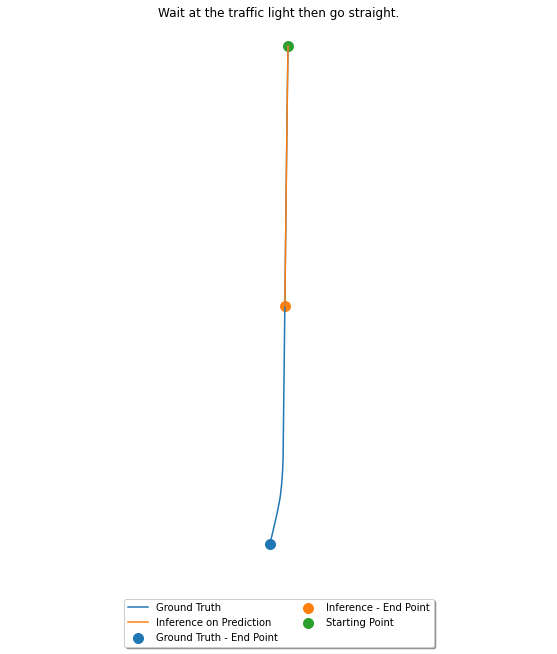

(73, 3) (73, 3)
Episode 14: Drive straight till the intersection and then turn left
Frechet Distance: 10.80607305872367
FDE Distance: 10.80607305872367
ADE Distance: 8.40878467969196
ADE Matched Distance: 0.3058122732603196


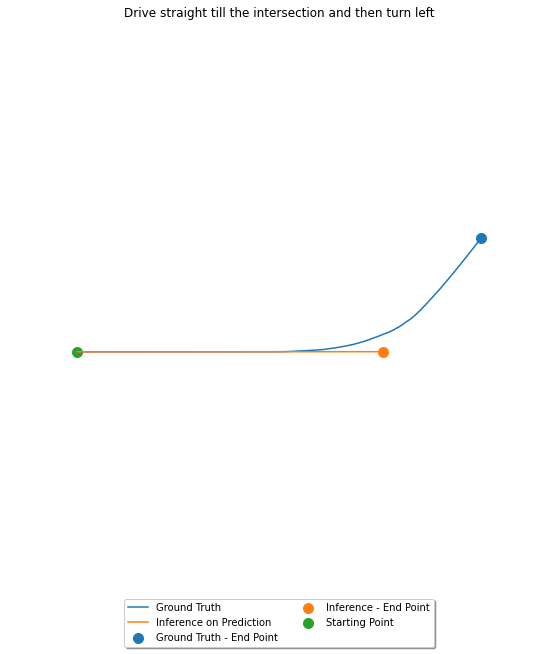

(239, 3) (239, 3)
Episode 15: go straight and take a left
Frechet Distance: 8.52316871708245
FDE Distance: 8.52316871708245
ADE Distance: 3.058633729966886
ADE Matched Distance: 0.6627953462575656


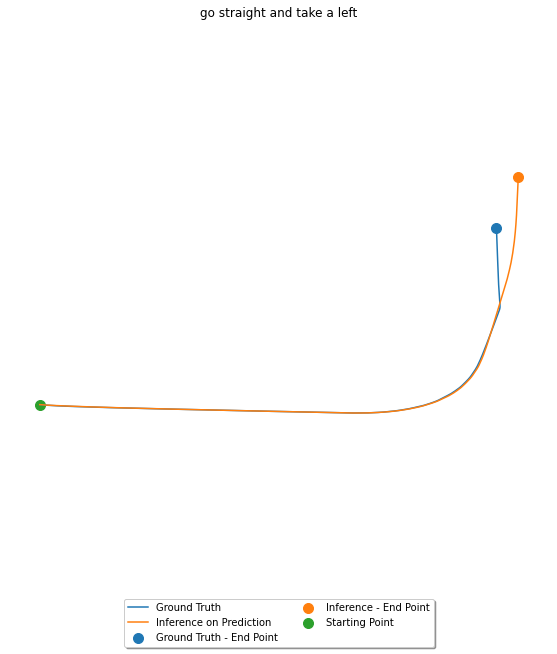

(47, 3) (47, 3)
Episode 16: Stop as soon as you encounter a white car
Frechet Distance: 2.624217095596366
FDE Distance: 2.624217095596366
ADE Distance: 1.4375775232215264
ADE Matched Distance: 0.14278952714151494


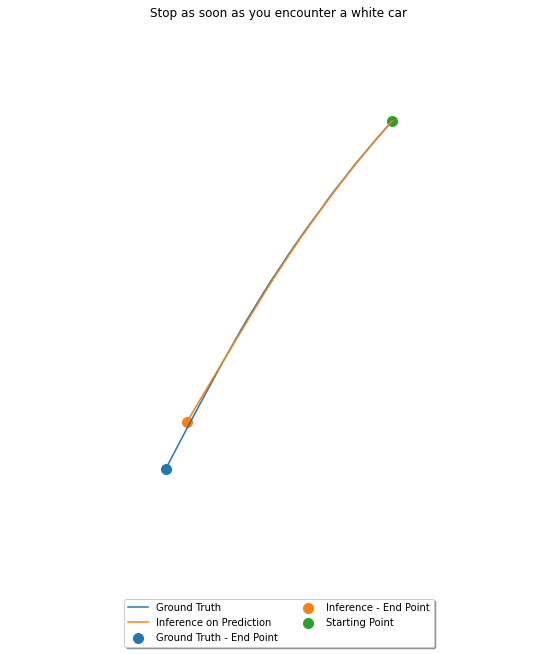

(105, 3) (105, 3)
Episode 17: take a right at the intersection
Frechet Distance: 22.106770483763352
FDE Distance: 22.106770483763356
ADE Distance: 6.574857080073169
ADE Matched Distance: 2.329441469050251


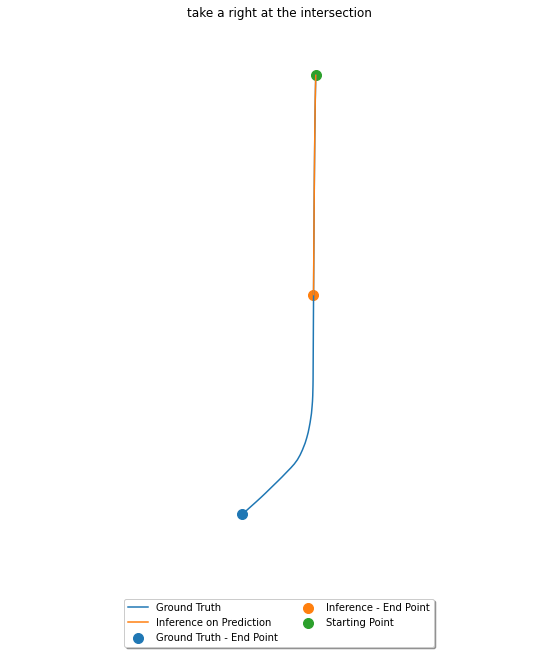

(44, 3) (44, 3)
Episode 18: Stop near the red shelters
Frechet Distance: 6.731877217354998
FDE Distance: 6.731877217354998
ADE Distance: 2.9144702204432447
ADE Matched Distance: 1.0327771119236706


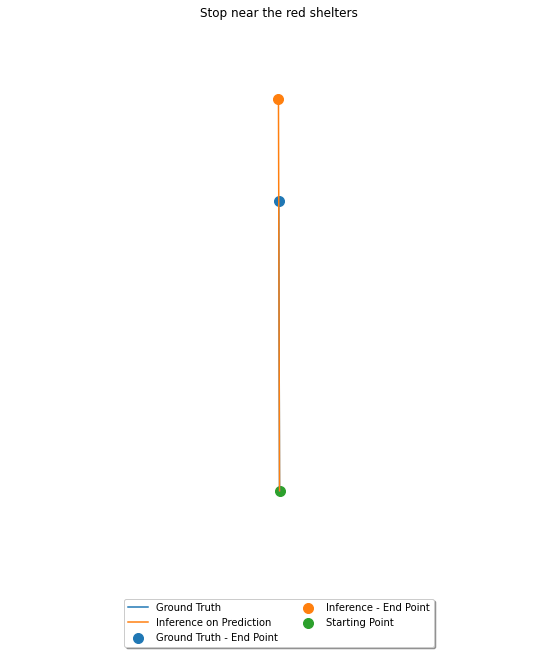

(127, 3) (127, 3)
Episode 19: Turn left from the intersection
Frechet Distance: 14.958527858630832
FDE Distance: 14.958527858630832
ADE Distance: 9.121601460723381
ADE Matched Distance: 0.5000660657941178


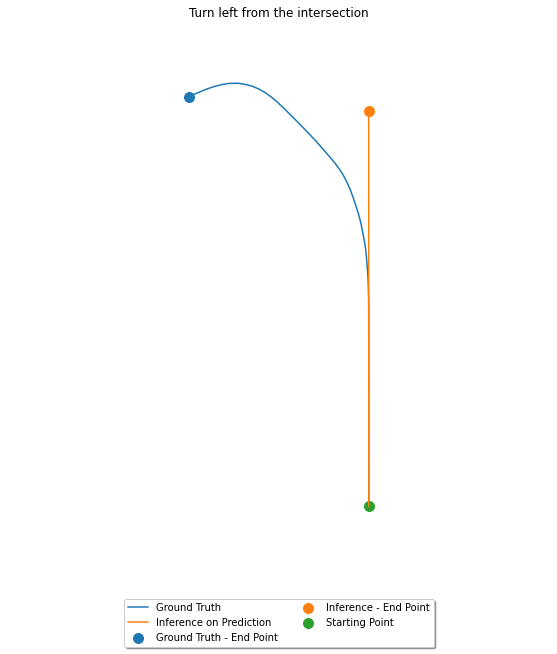

(127, 3) (127, 3)
Episode 20: Drive straight then turn right
Frechet Distance: 5.869629195004398
FDE Distance: 5.869629195004397
ADE Distance: 4.645239118928
ADE Matched Distance: 0.4940127749030362


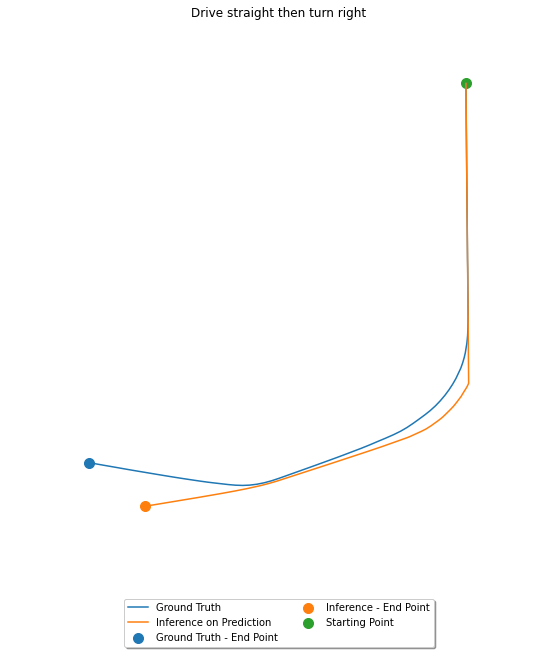

(36, 3) (36, 3)
Episode 21: Park near the hut visible on the right
Frechet Distance: 3.301101618035883
FDE Distance: 3.301101618035883
ADE Distance: 2.2673032663911727
ADE Matched Distance: 0.4567560332240104


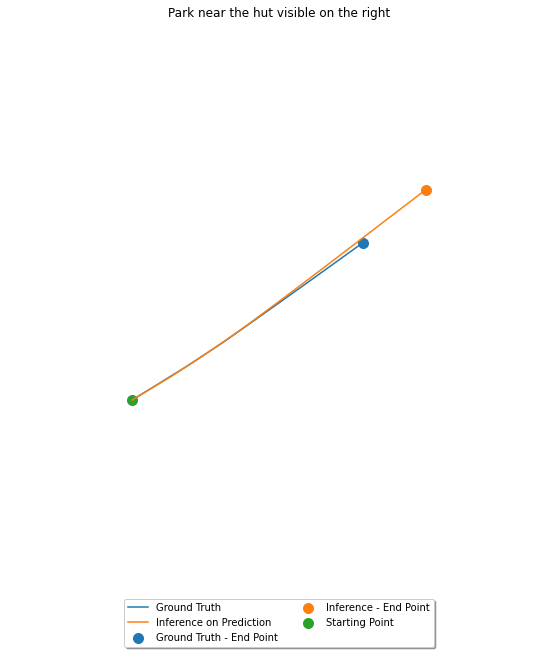

(170, 3) (170, 3)
Episode 22: Go straight and stop before the traffic light.
Frechet Distance: 18.890047461973513
FDE Distance: 18.890047461973516
ADE Distance: 17.353452479767846
ADE Matched Distance: 2.9217131737928526


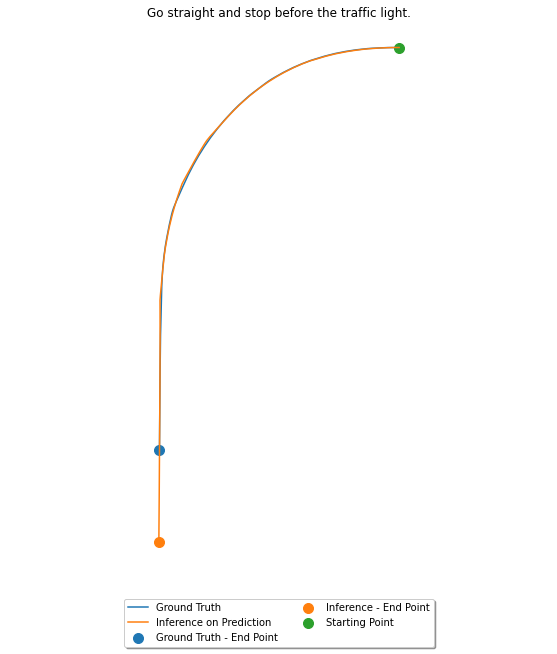

(136, 3) (136, 3)
Episode 23: stop at the bus stand in front
Frechet Distance: 16.67356110854315
FDE Distance: 16.67356110854315
ADE Distance: 8.394737610482593
ADE Matched Distance: 0.6296646039969835


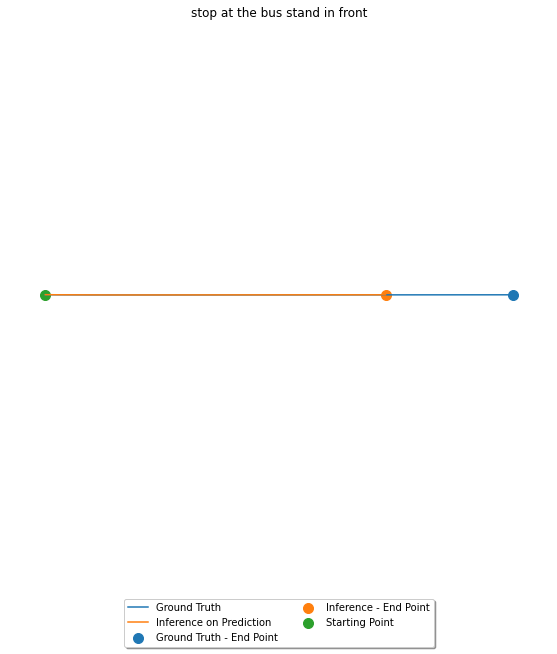

(66, 3) (66, 3)
Episode 24: Turn right from the intersection.
Frechet Distance: 1.4556376959438118
FDE Distance: 1.4556376959438118
ADE Distance: 2.1125523444447154
ADE Matched Distance: 0.28653614243005576


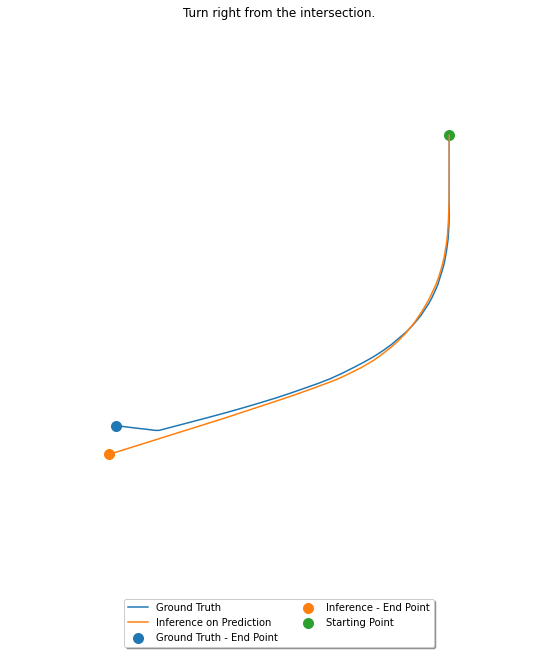

In [10]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/val/'
val_run_path = '/ssd_scratch/cvit/varunc/val_clip_6frames/'
save_loc = '../trajectories_val_clip6/'

frechet_val_clip_6,fde_val_clip_6,ade_val_clip_6, ade_matched_val_clip_6 = get_scores(val_data_path, val_run_path, save_loc,episodes=list(range(25)))

subplotting
(45, 3) (45, 3)
Episode 11: After crossing the blue car come to a stop
Frechet Distance: 2.2496643059118075
FDE Distance: 2.2496643059118075
ADE Distance: 2.2260000615720372
ADE Matched Distance: 0.11379863268316082
subplotting
(66, 3) (66, 3)
Episode 14: Turn right from the intersection.
Frechet Distance: 7.521698756749053
FDE Distance: 7.521698756749053
ADE Distance: 4.718412440708598
ADE Matched Distance: 0.9440076470747767
[<matplotlib.lines.Line2D object at 0x147d3207f750>, <matplotlib.lines.Line2D object at 0x147d3207f9d0>, <matplotlib.collections.PathCollection object at 0x147d3207fa10>, <matplotlib.collections.PathCollection object at 0x147d3207fcd0>, <matplotlib.collections.PathCollection object at 0x147d320136d0>] ['Ground Truth', 'Inference on Prediction', 'Ground Truth - End Point', 'Inference - End Point', 'Starting Point']


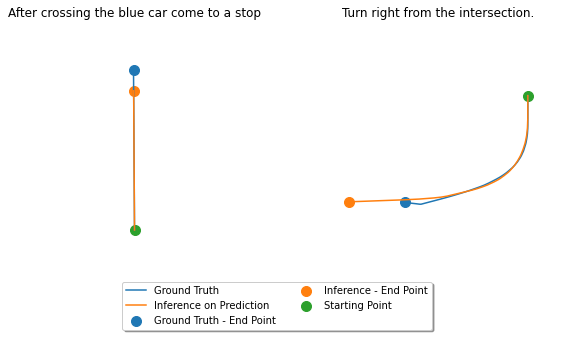

([2.2496643059118075, 7.521698756749053],
 [2.2496643059118075, 7.521698756749053],
 [2.2260000615720372, 4.718412440708598],
 [0.11379863268316082, 0.9440076470747767])

In [135]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/val/'
val_run_path = '/ssd_scratch/cvit/varunc/val5_conv3d/'
save_loc = '../trajectories_temp'

get_scores(val_data_path, val_run_path, save_loc,episodes = [11,14],subplots=[121,122])

(58, 3) (58, 3)
Episode 0: Stop before the next right turn.
Frechet Distance: 289.5359727101078
FDE Distance: 289.5359727101078
ADE Distance: 279.00017460373545
ADE Matched Distance: 273.3042236483292


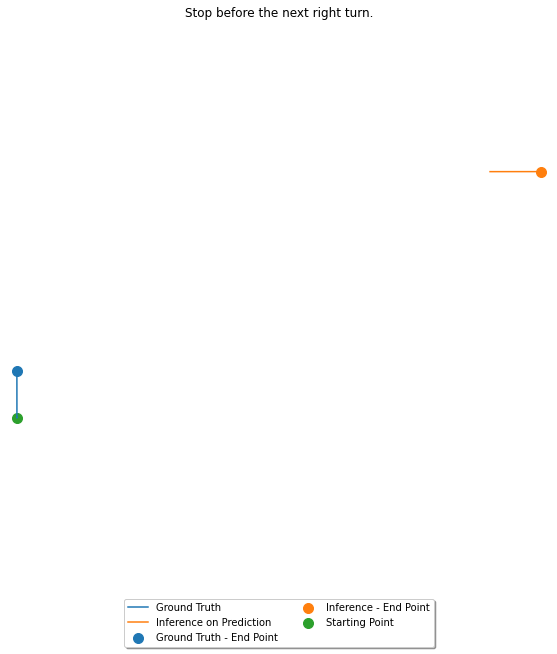

(45, 3) (45, 3)
Episode 1: After crossing the blue car come to a stop
Frechet Distance: 11.244383240717495
FDE Distance: 11.244383240717495
ADE Distance: 4.865356325087732
ADE Matched Distance: 1.704707179088633


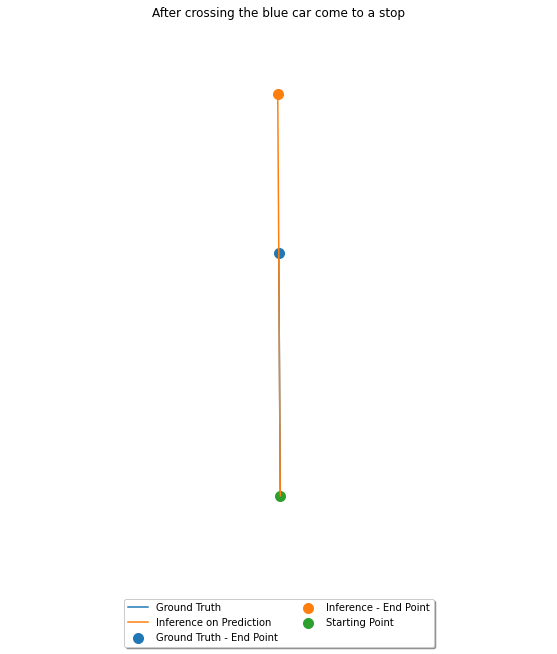

(109, 3) (109, 3)
Episode 2: stop beside the black suv
Frechet Distance: 0.9799679056257724
FDE Distance: 0.9799679056257724
ADE Distance: 1.7897927263416173
ADE Matched Distance: 0.11270105182259373


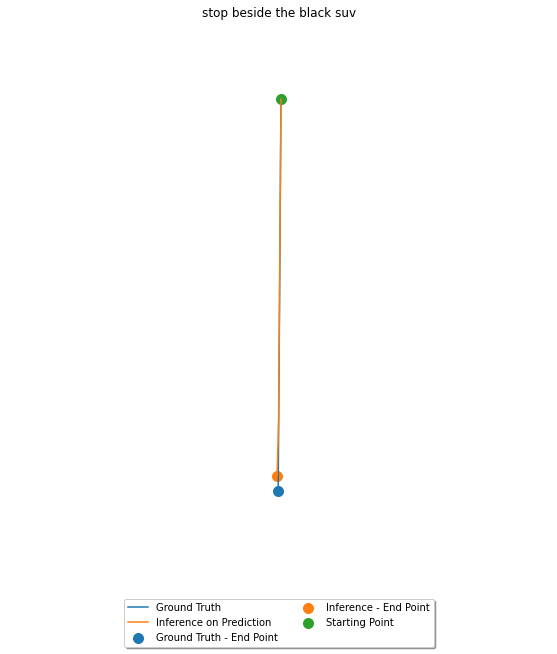

(38, 3) (38, 3)
Episode 3: Stop near the signboard
Frechet Distance: 2.3202248617807157
FDE Distance: 2.3202248617807153
ADE Distance: 1.9540218487231793
ADE Matched Distance: 0.24470090084280155


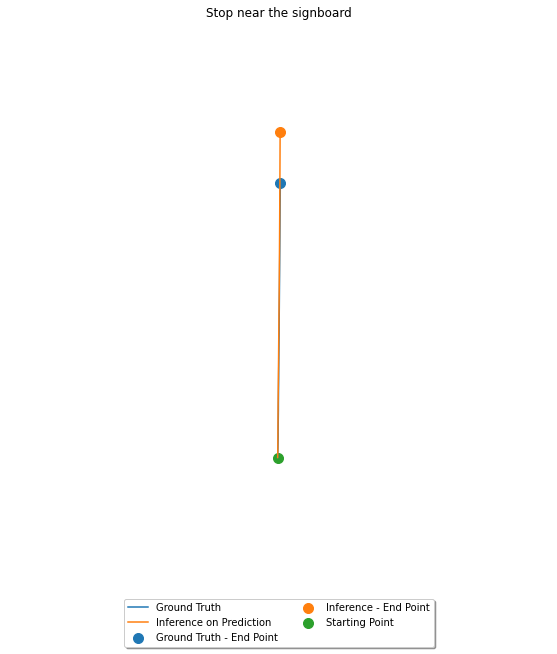

(82, 3) (82, 3)
Episode 4: Take a left at the traffic light
Frechet Distance: 3.2668516526350047
FDE Distance: 3.2668516526350047
ADE Distance: 1.378177521494573
ADE Matched Distance: 0.19479404082679844


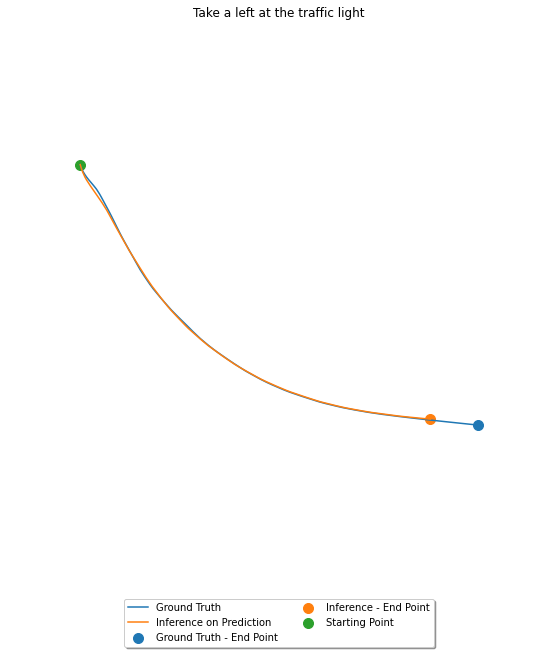

(57, 3) (57, 3)
Episode 5: Turn right from the intersection
Frechet Distance: 5.893298083657999
FDE Distance: 5.893298083657999
ADE Distance: 2.056530290379942
ADE Matched Distance: 0.5900597498081411


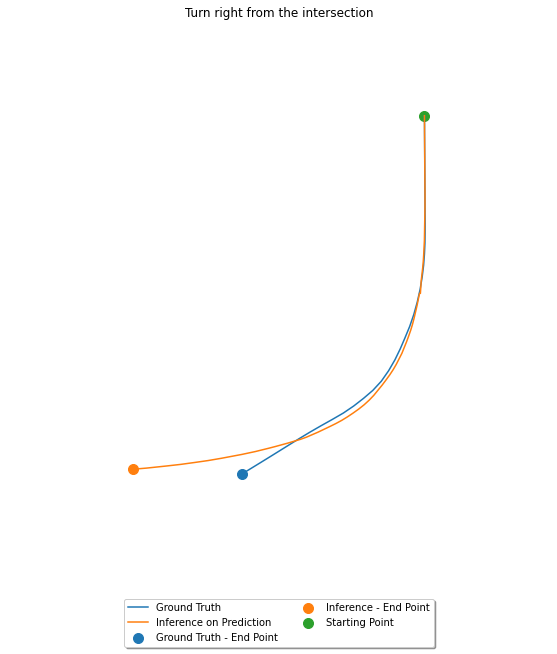

(91, 3) (91, 3)
Episode 6: Take a left from the intersection ahead
Frechet Distance: 4.356750893271458
FDE Distance: 4.356750893271458
ADE Distance: 4.304080322494528
ADE Matched Distance: 0.9627861621410074


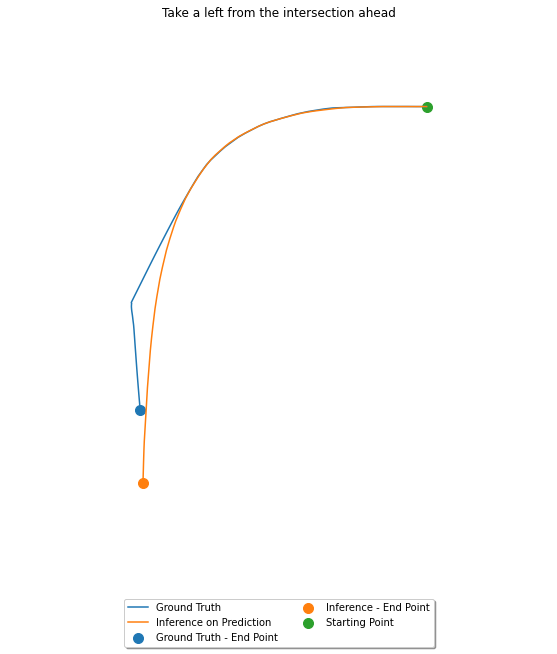

(61, 3) (61, 3)
Episode 7: Drive to the corner and go right
Frechet Distance: 26.428901456967285
FDE Distance: 26.428901456967285
ADE Distance: 6.218774923647011
ADE Matched Distance: 4.027028632127736


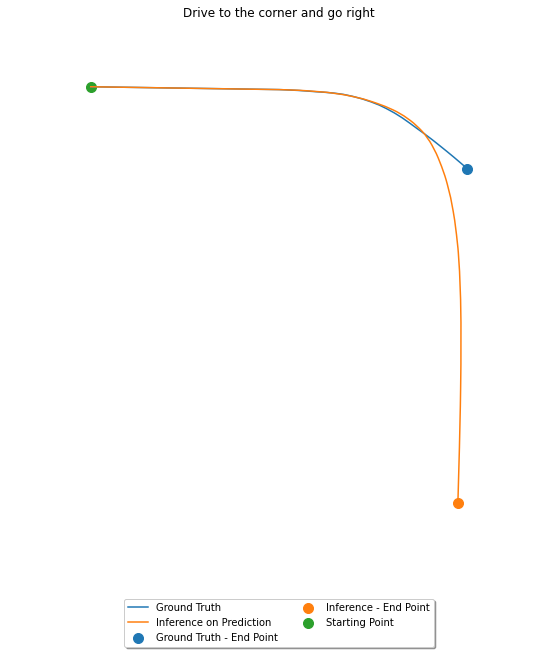

(83, 3) (83, 3)
Episode 8: Drive to the intersection and turn left
Frechet Distance: 9.317058335266461
FDE Distance: 9.317058335266461
ADE Distance: 3.623387560792672
ADE Matched Distance: 0.8663751427634475


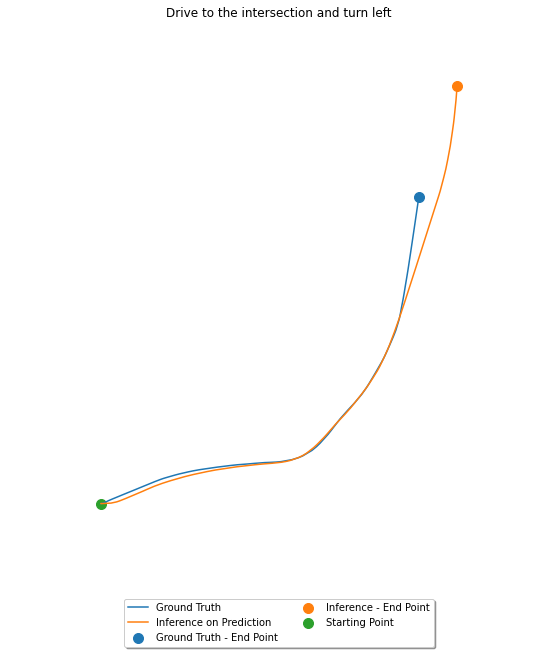

(177, 3) (177, 3)
Episode 9: Go straight and stop a few metres ahead of the bus stop
Frechet Distance: 3.098182922677559
FDE Distance: 3.098182922677559
ADE Distance: 7.939733239906236
ADE Matched Distance: 0.18928223425633967


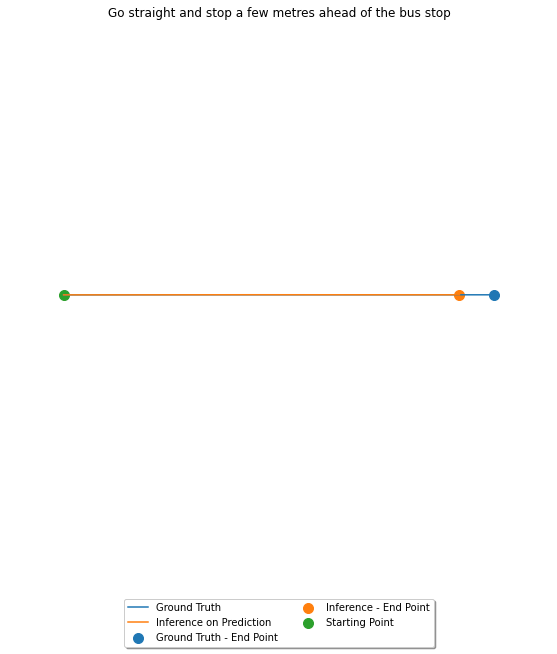

(80, 3) (80, 3)
Episode 10: Stop in front of the garbage dumpsters.
Frechet Distance: 2.574905606142252
FDE Distance: 2.574905606142252
ADE Distance: 2.8002062742461744
ADE Matched Distance: 0.1576797181382821


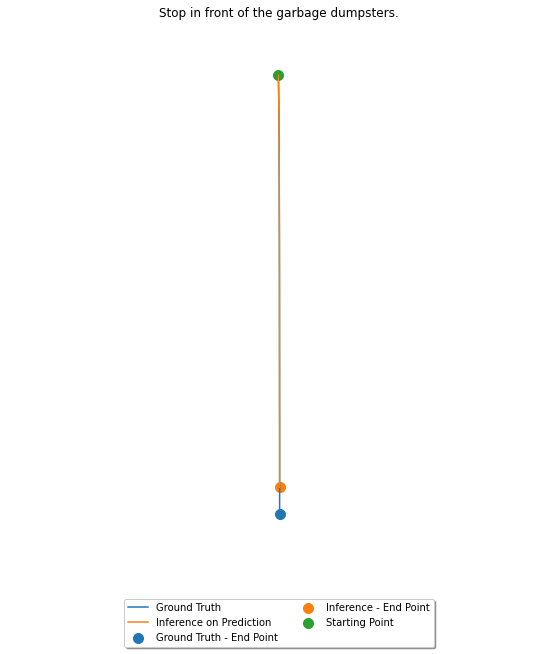

(107, 3) (107, 3)
Episode 11: Go straight and stop next to the grey arch.
Frechet Distance: 39.37425020141003
FDE Distance: 39.37425020141003
ADE Distance: 15.068082258229662
ADE Matched Distance: 9.43306295306722


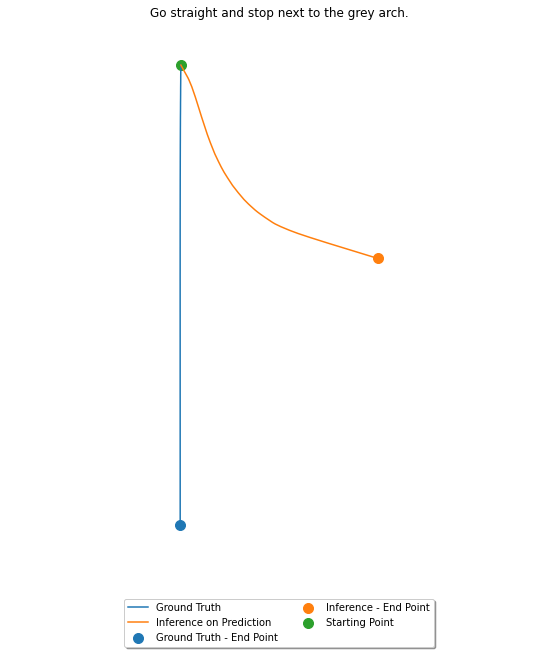

(66, 3) (66, 3)
Episode 12: Change lanes and stop at the junction.
Frechet Distance: 12.074255658160272
FDE Distance: 12.074255658160272
ADE Distance: 4.1651169133645825
ADE Matched Distance: 3.1413438928796538


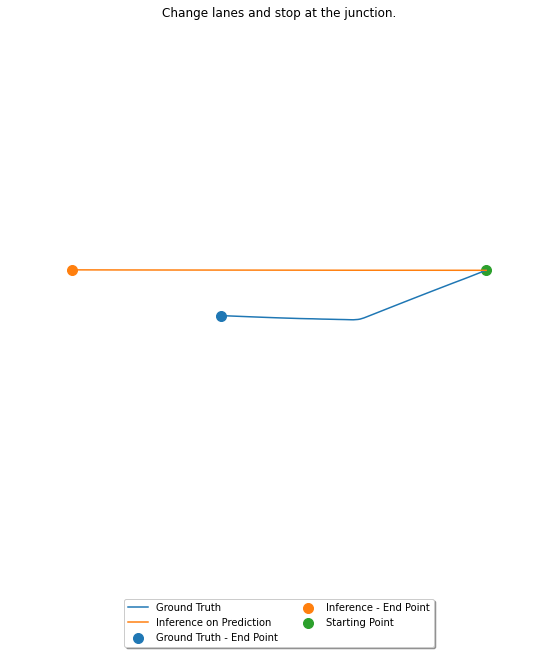

(60, 3) (60, 3)
Episode 13: Park on the roadside after you have crossed the bus stop
Frechet Distance: 13.235917497971958
FDE Distance: 13.23591749797196
ADE Distance: 5.529658444010938
ADE Matched Distance: 2.4884657930663976


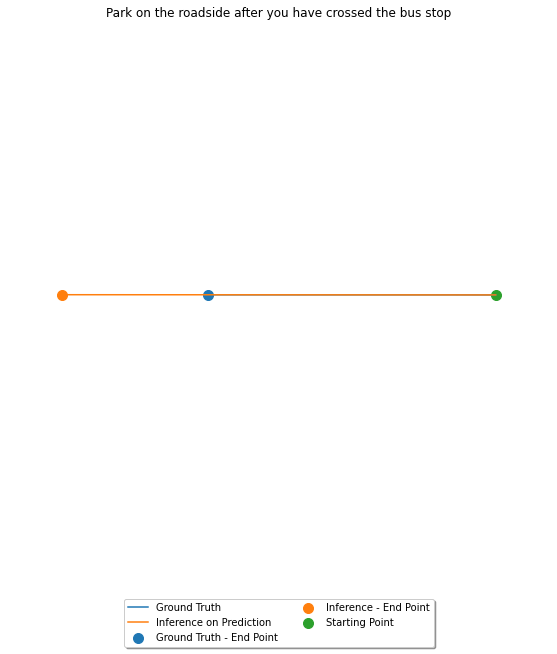

(452, 3) (452, 3)
Episode 14: Wait for the signal to turn green and continue straight
Frechet Distance: 28.93699635577502
FDE Distance: 28.93699635577502
ADE Distance: 3.7302599096857585
ADE Matched Distance: 1.472104531724757


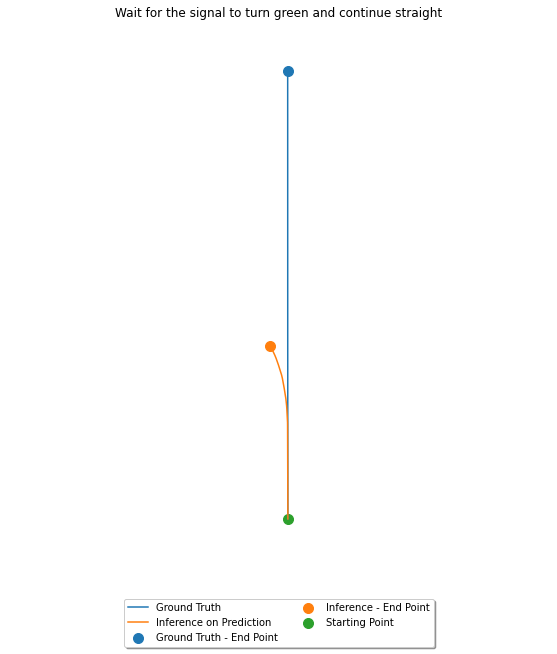

(63, 3) (63, 3)
Episode 15: Drive towards the bus stop and park after crossing it
Frechet Distance: 1.9442843694884497
FDE Distance: 1.9442843694884495
ADE Distance: 3.557048088809549
ADE Matched Distance: 0.13394131896192055


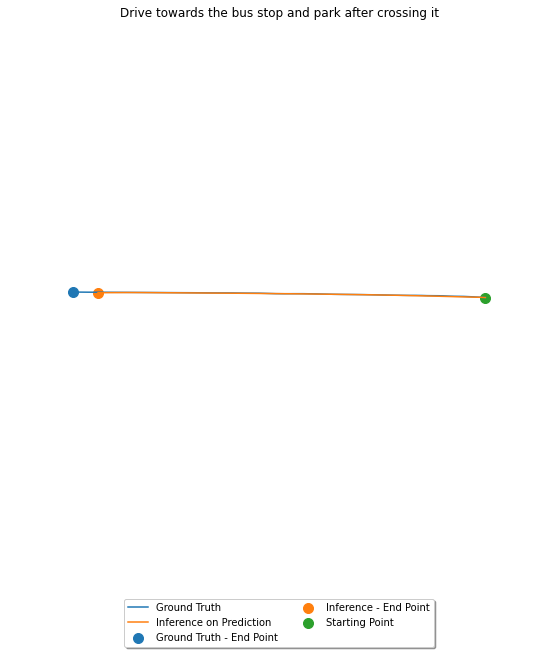

(81, 3) (81, 3)
Episode 16: take a right turn and stop across the bench on left
Frechet Distance: 3.1764986008763008
FDE Distance: 3.176498600876301
ADE Distance: 2.357357832272487
ADE Matched Distance: 0.2704379919006537


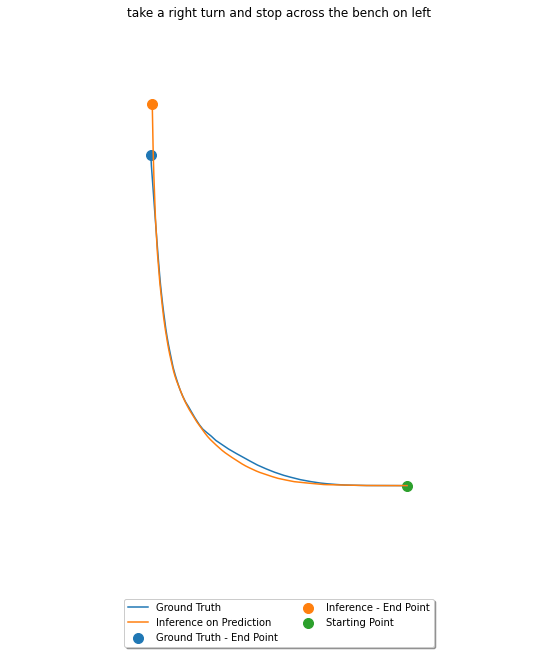

(61, 3) (61, 3)
Episode 17: Turn right from the crossroads ahead
Frechet Distance: 17.492453152472066
FDE Distance: 17.492453152472066
ADE Distance: 5.039175345340617
ADE Matched Distance: 4.022449369958488


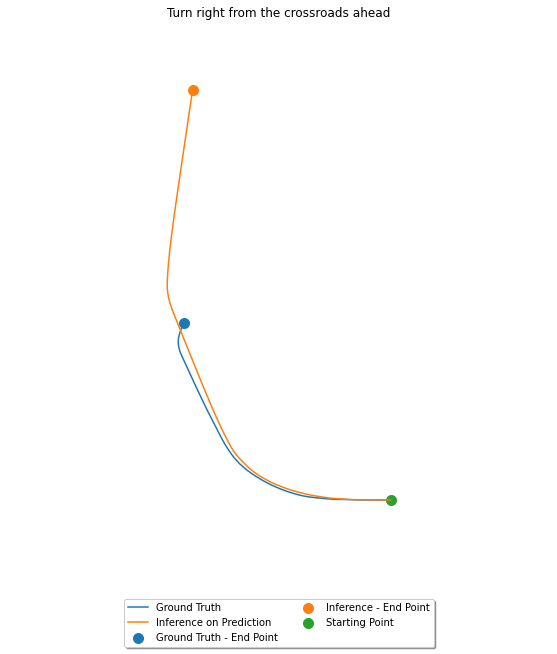

(156, 3) (156, 3)
Episode 18: Turn right and park near the sidewalk.
Frechet Distance: 52.14609446114805
FDE Distance: 3.6967815832184288
ADE Distance: 40.14002021353196
ADE Matched Distance: 33.34082753722543


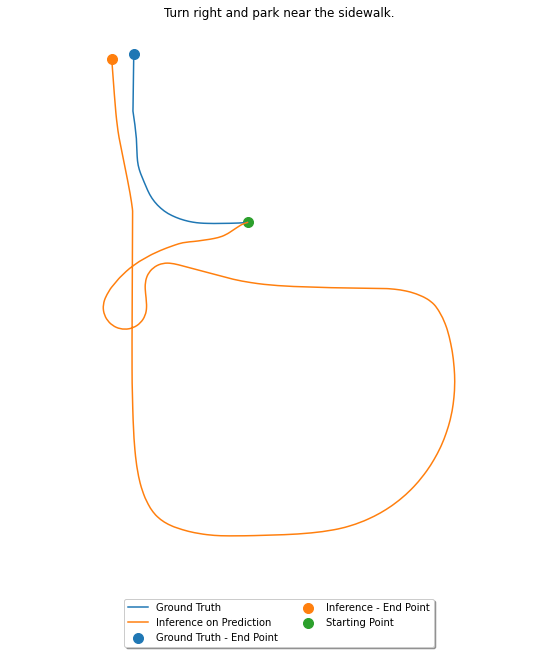

(136, 3) (136, 3)
Episode 19: go straight and take a right
Frechet Distance: 7.550306899089149
FDE Distance: 7.550306899089149
ADE Distance: 2.713435012673337
ADE Matched Distance: 1.1898034427818553


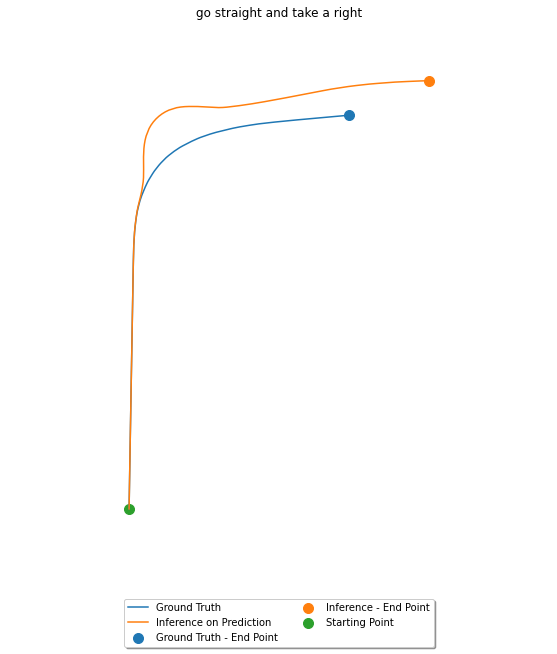

(42, 3) (42, 3)
Episode 20: park beside the red volkswagen
Frechet Distance: 9.763152847526246
FDE Distance: 9.763152847526246
ADE Distance: 3.3039358973558524
ADE Matched Distance: 1.4017213150284824


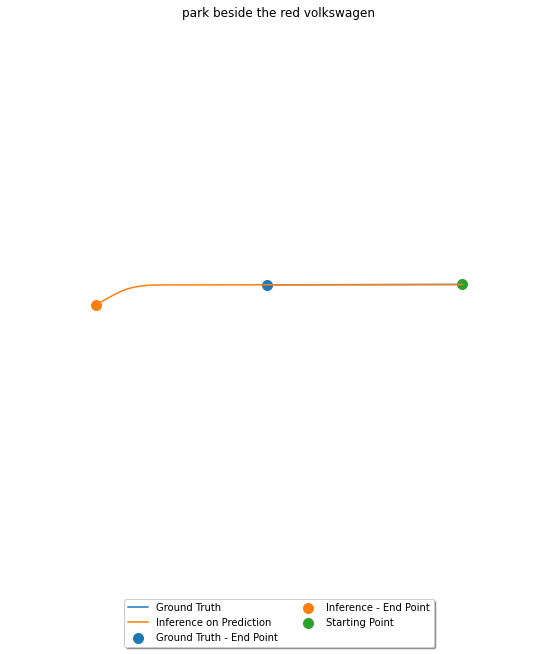

(147, 3) (147, 3)
Episode 21: Turn left from the next crossroads
Frechet Distance: 12.062184856671966
FDE Distance: 12.062184856671966
ADE Distance: 7.563267990601123
ADE Matched Distance: 0.44398995869851104


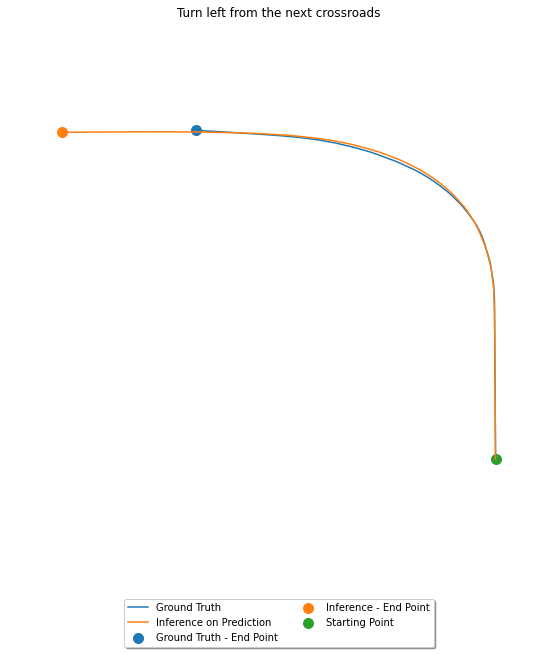

(66, 3) (66, 3)
Episode 22: Turn right from the crossroads.
Frechet Distance: 5.369668918853363
FDE Distance: 5.369668918853363
ADE Distance: 2.9242137252906644
ADE Matched Distance: 0.5624979669774022


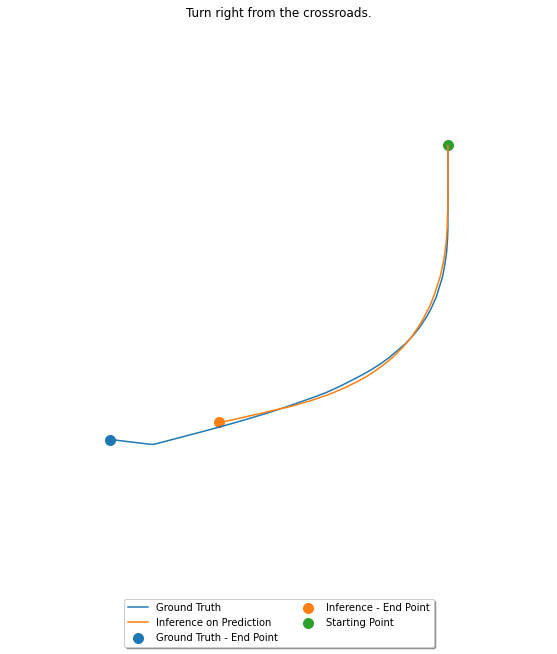

(71, 3) (71, 3)
Episode 23: stop by the lamp post
Frechet Distance: 9.204152843598298
FDE Distance: 9.204152843598298
ADE Distance: 7.979028987635332
ADE Matched Distance: 1.121148427040731


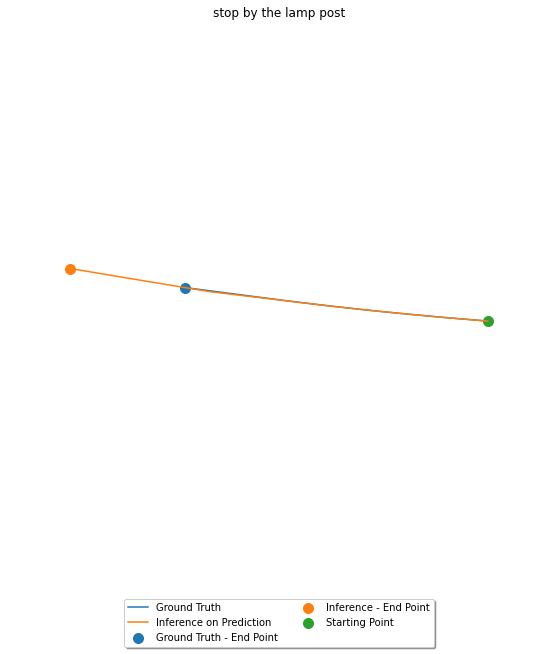

(50, 3) (50, 3)
Episode 24: park immediately after the signboard
Frechet Distance: 1.9351348911650639
FDE Distance: 1.9351348911650639
ADE Distance: 2.1337312132863095
ADE Matched Distance: 0.1081693874705114


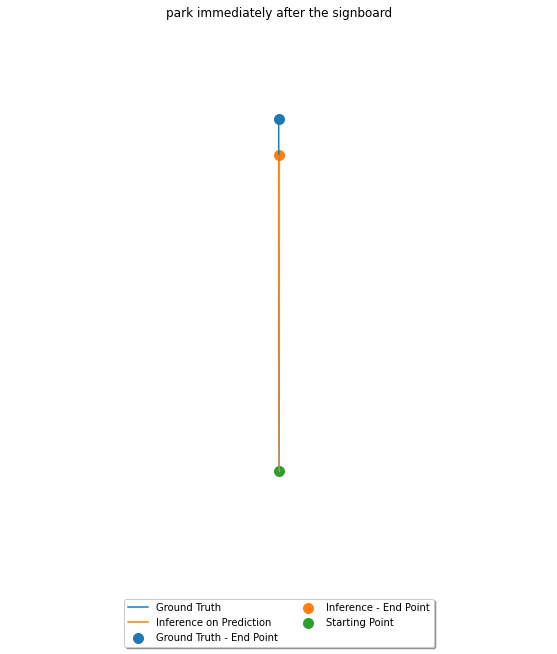

(176, 3) (176, 3)
Episode 25: Turn right and stop beside the traffic signal
Frechet Distance: 6.591470891868005
FDE Distance: 6.591470891868005
ADE Distance: 11.478924557657708
ADE Matched Distance: 0.4420902155738211


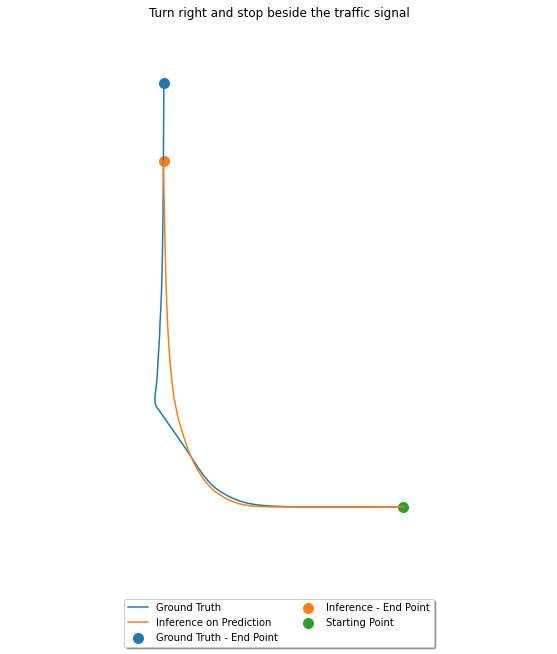

(398, 3) (398, 3)
Episode 26: Turn left and stop near the traffic signal
Frechet Distance: 10.34281159909459
FDE Distance: 10.34281159909459
ADE Distance: 15.807824312160696
ADE Matched Distance: 0.5835690680225394


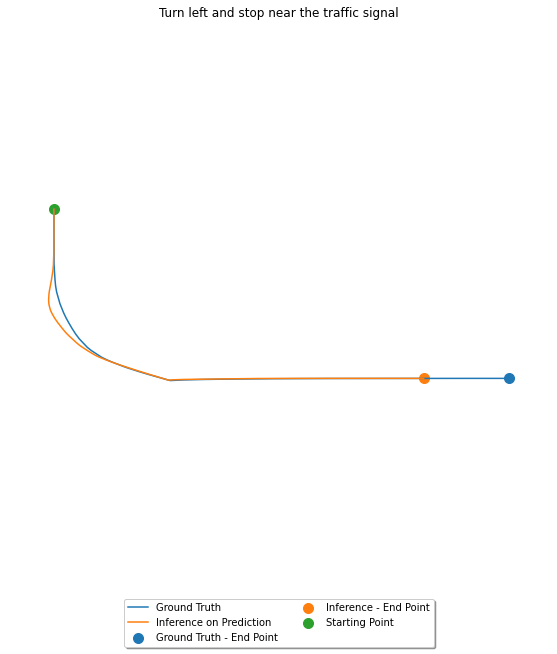

(358, 3) (358, 3)
Episode 27: Turn left and stop near the intersection
Frechet Distance: 8.325129479407924
FDE Distance: 8.325129479407924
ADE Distance: 31.980369354036696
ADE Matched Distance: 2.658515517855259


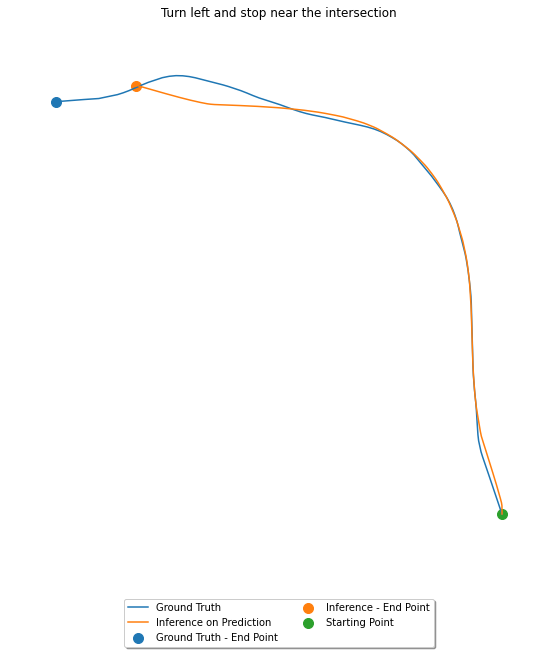

(501, 3) (501, 3)
Episode 28: Turn left and come to a halt at the intersection
Frechet Distance: 38.42952985929697
FDE Distance: 38.42952985929696
ADE Distance: 14.480199681055748
ADE Matched Distance: 2.822385533498976


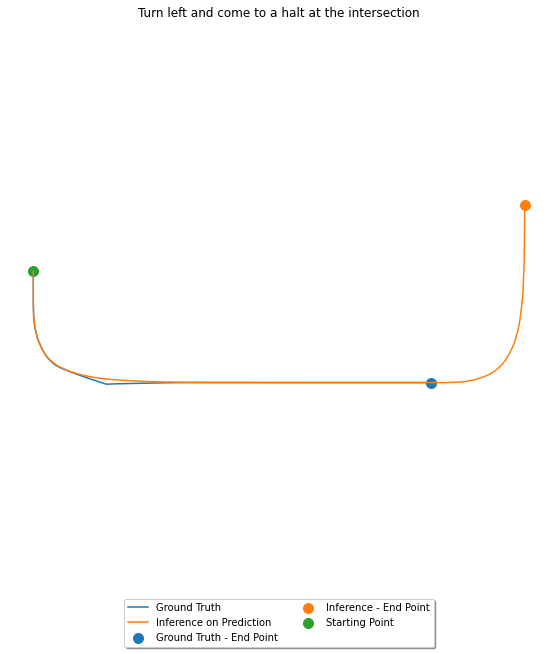

(194, 3) (194, 3)
Episode 29: Turn right and stop before the traffic signal
Frechet Distance: 4.644824785026458
FDE Distance: 4.644824785026458
ADE Distance: 3.9716762981002764
ADE Matched Distance: 0.9036502328784043


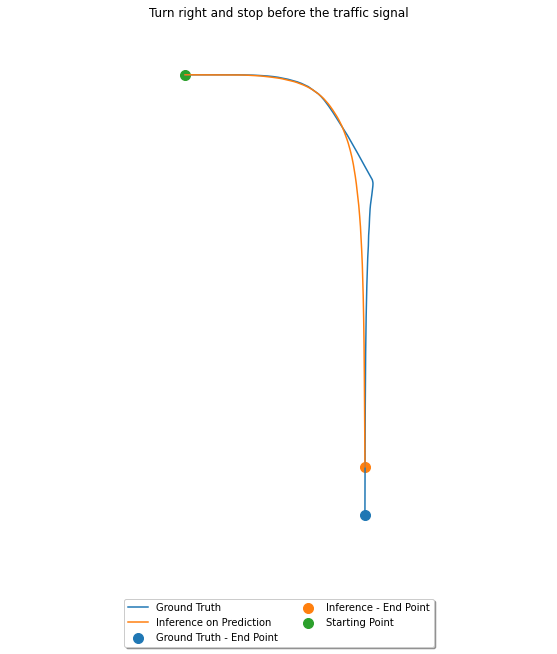

(153, 3) (153, 3)
Episode 30: Turn right and stop just before the traffic signal
Frechet Distance: 72.26843250110707
FDE Distance: 72.26843250110707
ADE Distance: 36.24847483124881
ADE Matched Distance: 28.101156004199172


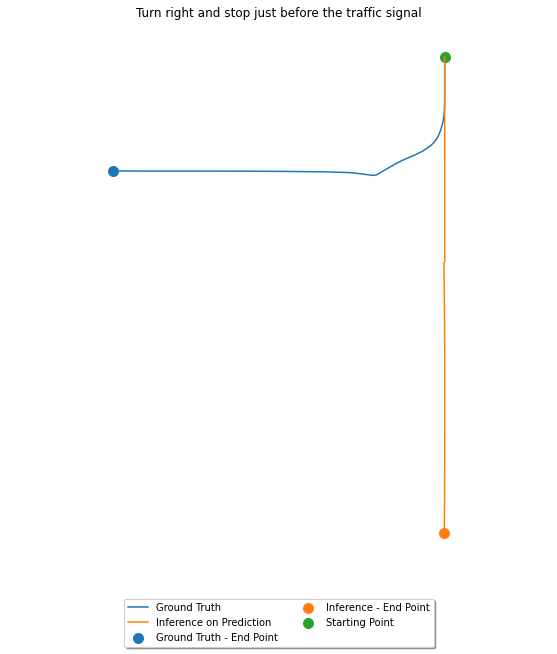

(216, 3) (216, 3)
Episode 31: Turn right and stop near the bus stop
Frechet Distance: 38.09871333687723
FDE Distance: 38.09871333687723
ADE Distance: 14.313420279092455
ADE Matched Distance: 10.330482187120856


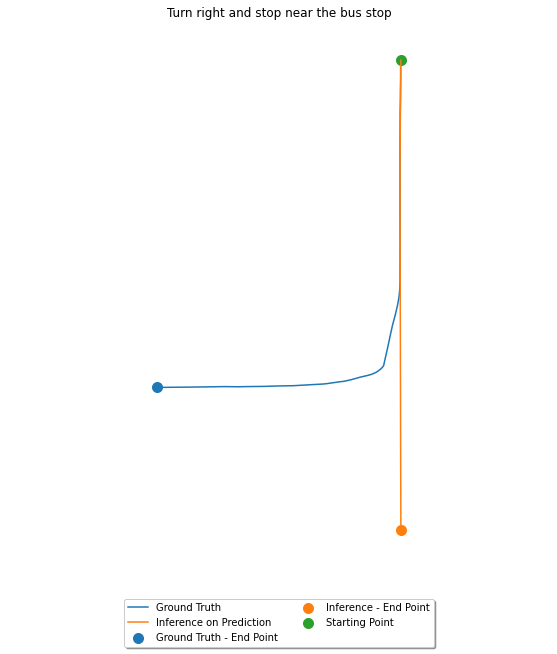

(188, 3) (188, 3)
Episode 32: Turn left and stop beside the traffic signal
Frechet Distance: 6.047905581424782
FDE Distance: 6.047905581424782
ADE Distance: 12.044058927744437
ADE Matched Distance: 0.09219189129959515


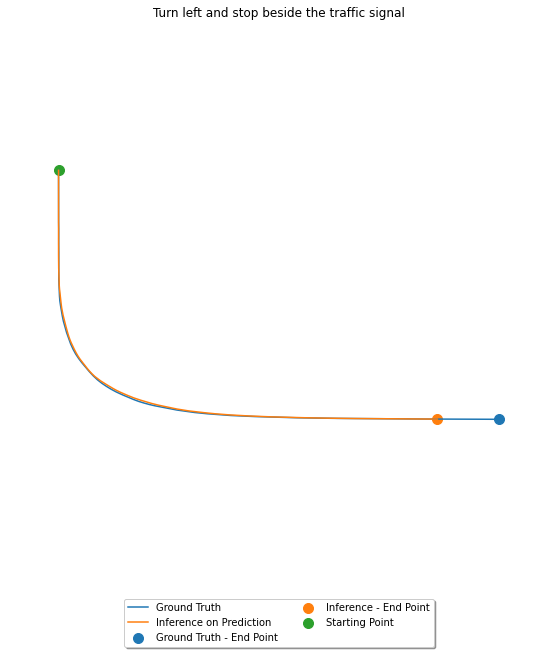

(166, 3) (166, 3)
Episode 33: Turn left and stop near the traffic signal
Frechet Distance: 43.341300475553865
FDE Distance: 43.341300475553865
ADE Distance: 29.793967140442735
ADE Matched Distance: 2.5482097901704694


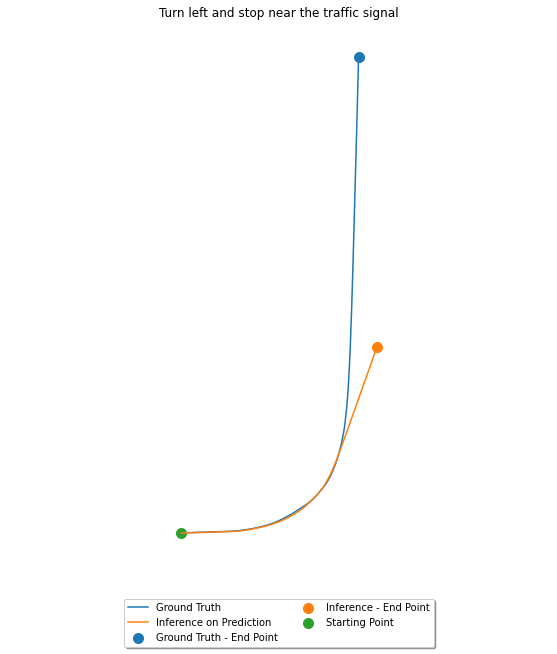

In [11]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/test/'
val_run_path = '/ssd_scratch/cvit/varunc/test_clip_6frames/'
save_loc = '../trajectories_test_clip6/'

frechet_test_clip_6,fde_test_clip_6,ade_test_clip_6, ade_matched_test_clip_6 = get_scores(val_data_path, val_run_path, save_loc,episodes=list(range(34)))

In [24]:
import math
trunc = lambda x: math.trunc(1000 * x) / 1000;

In [19]:
frechet_df = pd.DataFrame({'Val':pd.Series(frechet_val_clip_6),'Test':pd.Series(frechet_test_clip_6)})
fde_df = pd.DataFrame({'Val':pd.Series(fde_val_clip_6),'Test':pd.Series(fde_test_clip_6)})
ade_df = pd.DataFrame({'Val':pd.Series(ade_val_clip_6),'Test':pd.Series(ade_test_clip_6)})
ade_match_df = pd.DataFrame({'Val':pd.Series(ade_matched_val_clip_6),'Test':pd.Series(ade_matched_test_clip_6)})

In [20]:
frechet_metric = pd.DataFrame([frechet_df.mean(),frechet_df.std(),frechet_df.median()],index=['Mean','STD','Median'])
frechet_metric['Metric'] = 'Frechet'

fde_metric = pd.DataFrame([fde_df.mean(),fde_df.std(),fde_df.median()],index=['Mean','STD','Median'])
fde_metric['Metric'] = 'FDE'

ade_metric = pd.DataFrame([ade_df.mean(),ade_df.std(),ade_df.median()],index=['Mean','STD','Median'])
ade_metric['Metric'] = 'ADE'

ade_match_metric = pd.DataFrame([ade_match_df.mean(),ade_match_df.std(),ade_match_df.median()],index=['Mean','STD','Median'])
ade_match_metric['Metric'] = 'ADE Match'

joined = pd.concat([frechet_metric,fde_metric,ade_metric,ade_match_metric])

joined['Measure'] = joined.index

joined = joined.set_index(['Metric','Measure'])

In [21]:
joined.T

Metric     Frechet                             FDE                       \
Measure       Mean        STD    Median       Mean        STD    Median   
Val      13.537746  13.130894  8.523169  13.536816  13.131824  8.523169   
Test     23.569764  49.973291  9.260606  22.144784  49.824289  8.764641   

Metric         ADE                       ADE Match                       
Measure       Mean        STD    Median       Mean        STD    Median  
Val       6.235008   4.283059  4.990485   1.812250   2.016621  0.662795  
Test     17.419220  47.347813  4.952266  11.469604  46.840572  1.041967

In [22]:
# joined.applymap(trunc).to_csv('joined.csv')

NameError: name 'trunc' is not defined

Text(0.5, 1.0, 'Freschet Distance')

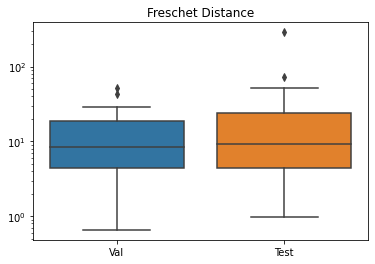

In [23]:
g = sns.boxplot(data=frechet_df)
g.set_yscale("log")
# g.set_ylim([-5,60])
plt.title('Freschet Distance')

Text(0.5, 1.0, 'FDE Distance')

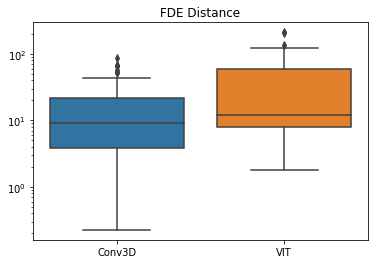

In [12]:
g = sns.boxplot(data=fde_df)
g.set_yscale("log")
plt.title('FDE Distance')

Text(0.5, 1.0, 'ADE Distance')

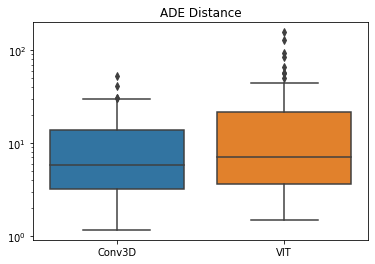

In [13]:
g = sns.boxplot(data=ade_df)
g.set_yscale("log")
plt.title('ADE Distance')

Text(0.5, 1.0, 'ADE Match Distance')

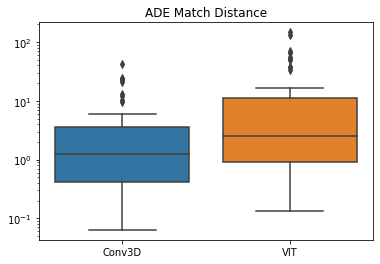

In [14]:
g = sns.boxplot(data=ade_match_df)
g.set_yscale("log")
plt.title('ADE Match Distance')

In [15]:
def get_ablations(commands):
    out = dict()
    for i,command in enumerate(commands):
        print(command)
        c_types = input('Type:')
        c_types = [ c.strip() for c in c_types.split(',')]
        for c_type in c_types:
            if c_type in out:
                out[c_type].append(i)
            else:
                out[c_type] = [i]
    return out

In [16]:
commands = get_commands('/ssd_scratch/cvit/varunc/carla_data/val/')

In [17]:
stop_turn = get_ablations(commands)

Stop after crossing the stop signboard


KeyboardInterrupt: Interrupted by user

In [18]:
stop_turn = {'stop': [0, 2, 4, 6, 9, 11, 12, 13, 15, 17, 18, 22, 24, 25, 29, 30, 31, 32, 33, 35, 36, 38, 39, 40, 41, 43, 44, 46, 47], 'left': [1, 3, 8, 10, 14, 15, 19, 26, 34, 42], 'right': [5, 7, 19, 21, 24, 27, 28, 32, 36, 37, 44, 45, 48, 49], 'straight': [16, 20, 23]}

In [19]:
stop_frechet_df = frechet_df.iloc[stop_turn['stop']].reset_index().drop('index',axis=1)
stop_fde_df = fde_df.iloc[stop_turn['stop']].reset_index().drop('index',axis=1)
stop_ade_df = ade_df.iloc[stop_turn['stop']].reset_index().drop('index',axis=1)
stop_ade_match_df = ade_match_df.iloc[stop_turn['stop']].reset_index().drop('index',axis=1)


stop_frechet_metric = pd.DataFrame([stop_frechet_df.mean(),stop_frechet_df.std(),stop_frechet_df.median()],index=['Mean','STD','Median'])
stop_frechet_metric['Metric'] = 'Frechet'

stop_fde_metric = pd.DataFrame([stop_fde_df.mean(),stop_fde_df.std(),stop_fde_df.median()],index=['Mean','STD','Median'])
stop_fde_metric['Metric'] = 'FDE'

stop_ade_metric = pd.DataFrame([stop_ade_df.mean(),stop_ade_df.std(),stop_ade_df.median()],index=['Mean','STD','Median'])
stop_ade_metric['Metric'] = 'ADE'

stop_ade_match_metric = pd.DataFrame([stop_ade_match_df.mean(),stop_ade_match_df.std(),stop_ade_match_df.median()],index=['Mean','STD','Median'])
stop_ade_match_metric['Metric'] = 'ADE Match'

stop_joined = pd.concat([stop_frechet_metric,stop_fde_metric,stop_ade_metric,stop_ade_match_metric])

stop_joined['Measure'] = stop_joined.index
stop_joined['Command Type'] = 'Stopping Based'
stop_joined = stop_joined.set_index(['Metric','Measure'])
stop_joined

Conv3D        VIT    Command Type
Metric    Measure                                      
Frechet   Mean     17.326682  53.981311  Stopping Based
          STD      21.375390  72.795143  Stopping Based
          Median    9.665442  12.282180  Stopping Based
FDE       Mean     17.316695  47.667016  Stopping Based
          STD      21.383593  60.744939  Stopping Based
          Median    9.665442  12.282180  Stopping Based
ADE       Mean     10.724657  26.614002  Stopping Based
          STD      12.428624  39.105454  Stopping Based
          Median    7.157681   7.676123  Stopping Based
ADE Match Mean      4.444001  20.895273  Stopping Based
          STD       9.003296  37.588336  Stopping Based
          Median    1.366873   3.702058  Stopping Based

In [20]:
turn_frechet_df = frechet_df.iloc[[*stop_turn['left'],*stop_turn['right']]].reset_index().drop('index',axis=1)
turn_fde_df = fde_df.iloc[[*stop_turn['left'],*stop_turn['right']]].reset_index().drop('index',axis=1)
turn_ade_df = ade_df.iloc[[*stop_turn['left'],*stop_turn['right']]].reset_index().drop('index',axis=1)
turn_ade_match_df = ade_match_df.iloc[[*stop_turn['left'],*stop_turn['right']]].reset_index().drop('index',axis=1)


turn_frechet_metric = pd.DataFrame([turn_frechet_df.mean(),turn_frechet_df.std(),turn_frechet_df.median()],index=['Mean','STD','Median'])
turn_frechet_metric['Metric'] = 'Frechet'

turn_fde_metric = pd.DataFrame([turn_fde_df.mean(),turn_fde_df.std(),turn_fde_df.median()],index=['Mean','STD','Median'])
turn_fde_metric['Metric'] = 'FDE'

turn_ade_metric = pd.DataFrame([turn_ade_df.mean(),turn_ade_df.std(),turn_ade_df.median()],index=['Mean','STD','Median'])
turn_ade_metric['Metric'] = 'ADE'

turn_ade_match_metric = pd.DataFrame([turn_ade_match_df.mean(),turn_ade_match_df.std(),turn_ade_match_df.median()],index=['Mean','STD','Median'])
turn_ade_match_metric['Metric'] = 'ADE Match'

turn_joined = pd.concat([turn_frechet_metric,turn_fde_metric,turn_ade_metric,turn_ade_match_metric])

turn_joined['Measure'] = turn_joined.index

turn_joined['Command Type'] = 'Turning Based'

turn_joined = turn_joined.set_index(['Metric','Measure'])
turn_joined

Conv3D        VIT   Command Type
Metric    Measure                                     
Frechet   Mean     17.970466  36.416590  Turning Based
          STD      21.371984  40.996674  Turning Based
          Median    6.965737  16.678068  Turning Based
FDE       Mean     17.970466  35.569278  Turning Based
          STD      21.371984  39.775306  Turning Based
          Median    6.965737  16.678068  Turning Based
ADE       Mean     10.017345  17.524459  Turning Based
          STD       9.300756  21.721663  Turning Based
          Median    5.041168  10.150757  Turning Based
ADE Match Mean      5.033972  11.398932  Turning Based
          STD       7.565082  18.248139  Turning Based
          Median    1.321265   3.451181  Turning Based

In [21]:
type_joined = pd.concat([stop_joined.reset_index(),turn_joined.reset_index()])
type_joined = type_joined.pivot_table(index=['Command Type','Metric'],columns='Measure',sort=False)
type_joined

Conv3D                             VIT  \
Measure                        Mean    Median        STD       Mean   
Command Type   Metric                                                 
Stopping Based Frechet    17.326682  9.665442  21.375390  53.981311   
               FDE        17.316695  9.665442  21.383593  47.667016   
               ADE        10.724657  7.157681  12.428624  26.614002   
               ADE Match   4.444001  1.366873   9.003296  20.895273   
Turning Based  Frechet    17.970466  6.965737  21.371984  36.416590   
               FDE        17.970466  6.965737  21.371984  35.569278   
               ADE        10.017345  5.041168   9.300756  17.524459   
               ADE Match   5.033972  1.321265   7.565082  11.398932   

                                                
Measure                      Median        STD  
Command Type   Metric                           
Stopping Based Frechet    12.282180  72.795143  
               FDE        12.282180  60.744939  
               ADE         7.676123  39.105454  
               ADE Match   3.702058  37.588336  
Turning Based  Frechet    16.678068  40.996674  
               FDE        16.678068  39.775306  
               ADE        10.150757  21.721663  
               ADE Match   3.451181  18.248139

In [143]:
type_joined.applymap(trunc).to_csv('type_joined.csv')

In [22]:
len_commands = [len(s.split()) for s in commands]

In [23]:
len_commands
length_commands = dict()
for i,len_c in enumerate(len_commands):
    if len_c in length_commands:
        length_commands[len_c].append(i)
    else:
        length_commands[len_c] = [i]


In [24]:
length_commands

{6: [0, 1, 14, 23, 34, 37, 38, 45, 48],
 9: [2, 15, 17, 26, 31, 40, 44],
 5: [3, 5, 7, 13, 18, 21, 22, 25, 27, 39, 43, 49],
 7: [4, 8, 10, 24, 28, 33, 35, 46],
 4: [6, 29, 42],
 12: [9, 19],
 8: [11, 16, 36, 47],
 11: [12, 32],
 10: [20, 30, 41]}

In [25]:
command_vals = dict()
for i,len_c in enumerate(len_commands):
    if len_c in command_vals:
        command_vals[len_c].append({'Conv3D':{
                                        'frechet':frechet_conv3d[i],
                                        'ade_match':ade_matched_conv3d[i],
                                        'ade':ade_conv3d[i],
                                        'fde':fde_conv3d[i]},
                                    'VIT':{
                                        'frechet':frechet_vit[i],
                                        'ade_match':ade_matched_vit[i],
                                        'ade':ade_vit[i],
                                        'fde':fde_vit[i]}
                                   })
    else:
        command_vals[len_c] = [{'Conv3D':{
                                        'frechet':frechet_conv3d[i],
                                        'ade_match':ade_conv3d[i],
                                        'ade':ade_conv3d[i],
                                        'fde':fde_conv3d[i]},
                                    'VIT':{
                                        'frechet':frechet_vit[i],
                                        'ade_match':ade_matched_vit[i],
                                        'ade':ade_vit[i],
                                        'fde':fde_vit[i]}
                                   }]


In [26]:
command_vals

{6: [{'Conv3D': {'frechet': 26.111845491426653,
    'ade_match': 41.2555774241194,
    'ade': 41.2555774241194,
    'fde': 26.111845491426653},
   'VIT': {'frechet': 90.59249842920809,
    'ade_match': 38.12549675972528,
    'ade': 44.33715923340456,
    'fde': 90.59249842920809}},
  {'Conv3D': {'frechet': 6.409774368995845,
    'ade_match': 1.5706127697530465,
    'ade': 4.132724146503285,
    'fde': 6.409774368995845},
   'VIT': {'frechet': 6.593041440555822,
    'ade_match': 0.4778890316451603,
    'ade': 3.5402183203237167,
    'fde': 6.593041440555822}},
  {'Conv3D': {'frechet': 7.521698756749053,
    'ade_match': 0.9440076470747767,
    'ade': 4.6012384977254674,
    'fde': 7.521698756749053},
   'VIT': {'frechet': 8.425640053997611,
    'ade_match': 1.1563228977490998,
    'ade': 3.154552474136442,
    'fde': 8.425640053997611}},
  {'Conv3D': {'frechet': 1.1752202891395593,
    'ade_match': 0.2761978171832063,
    'ade': 1.908408684043676,
    'fde': 1.1752004228828945},
   'VIT

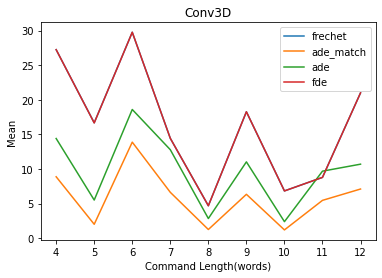

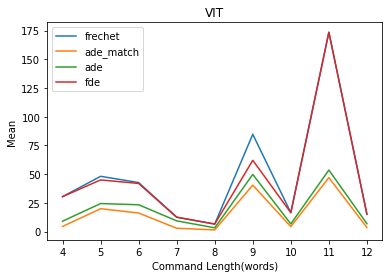

In [27]:
l_cv = sorted([(k,v) for k,v in command_vals.items()],key = lambda it: it[0])
for model in ['Conv3D','VIT']:
    plt.figure()
    for metric in ['frechet','ade_match','ade','fde']:
        x = [k for k,v in l_cv]
        y = [np.mean([t[model][metric] for t in v]) for k,v in l_cv]
        plt.plot(x,y,label = metric)
    plt.title(model)
    plt.legend()
    plt.ylabel('Mean')
    plt.xlabel('Command Length(words)')
    plt.show()

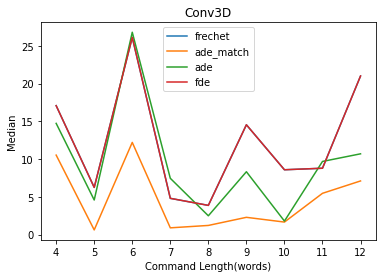

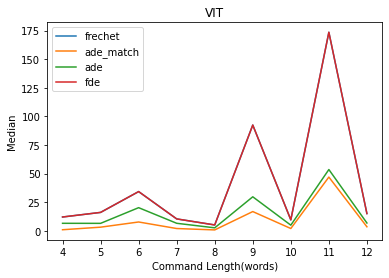

In [28]:
l_cv = sorted([(k,v) for k,v in command_vals.items()],key = lambda it: it[0])
for model in ['Conv3D','VIT']:
    plt.figure()
    for metric in ['frechet','ade_match','ade','fde']:
        x = [k for k,v in l_cv]
        y = [np.median([t[model][metric] for t in v]) for k,v in l_cv]
        plt.plot(x,y,label = metric)
    plt.title(model)
    plt.legend()
    plt.ylabel('Median')
    plt.xlabel('Command Length(words)')
    plt.show()

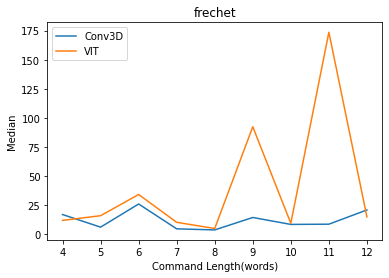

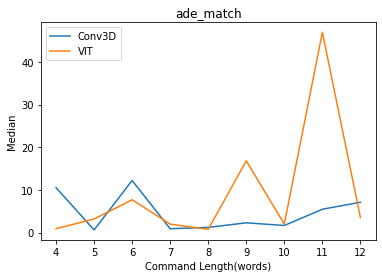

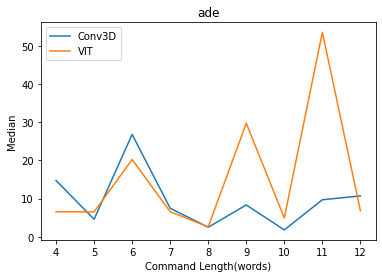

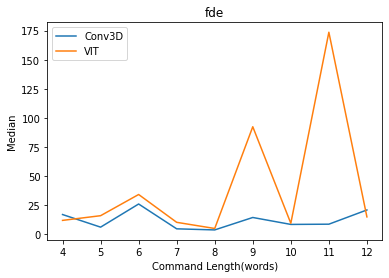

In [29]:
l_cv = sorted([(k,v) for k,v in command_vals.items()],key = lambda it: it[0])
for metric in ['frechet','ade_match','ade','fde']:
    plt.figure()
    for model in ['Conv3D','VIT']:
        x = [k for k,v in l_cv]
        y = [np.median([t[model][metric] for t in v]) for k,v in l_cv]
        plt.plot(x,y,label = model)
    plt.title(metric)
    plt.legend()
    plt.ylabel('Median')
    plt.xlabel('Command Length(words)')
    plt.show()

In [30]:
sub_command_count = get_ablations(commands)

Stop after crossing the stop signboard
Type:1
go straight and take a left
Type:2
After crossing the blue car come to a stop
Type:1
Turn left from the intersection
Type:1
Change lanes and stop at the junction.
Type:2
Drive straight then turn right.
Type:1
Stop near the signboard
Type:1
Turn right from the crossroads.
Type:1
Drive to the intersection and turn left
Type:2
Go straight and stop a few metres ahead of the bus stop
Type:1
Take a left from the intersection ahead.
Type:1
Park near the hut visible on the right
Type:1
Park on the roadside after you have crossed the bus stop
Type:1
park immediately after the signboard
Type:1
Take a left from the interection.
Type:1
Turn left and stop next to the bus stop.
Type:2
Wait at the traffic light then go straight.
Type:2
Stop as soon as you encounter a white car
Type:1
stop beside the black suv
Type:1
take a right at the traffic lights and then take a left
Type:2
Wait for the signal to turn green and continue straight
Type:2
Take the next r

In [33]:
sub_command_count = {'1': [0, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 17, 18, 21, 22, 23, 25, 27, 29, 31, 33, 34, 35, 37, 38, 39, 42, 43, 45, 46, 47, 48, 49], '2': [1, 4, 8, 15, 16, 19, 20, 24, 26, 28, 30, 32, 36, 40, 41, 44]}

In [34]:
target_type = get_ablations(commands)

Stop after crossing the stop signboard
Type:infra
go straight and take a left
Type:road
After crossing the blue car come to a stop
Type:auto
Turn left from the intersection
Type:road
Change lanes and stop at the junction.
Type:road
Drive straight then turn right.
Type:road
Stop near the signboard
Type:infra
Turn right from the crossroads.
Type:road
Drive to the intersection and turn left
Type:road
Go straight and stop a few metres ahead of the bus stop
Type:infra
Take a left from the intersection ahead.
Type:road
Park near the hut visible on the right
Type:infra
Park on the roadside after you have crossed the bus stop
Type:infra
park immediately after the signboard
Type:infra
Take a left from the interection.
Type:road
Turn left and stop next to the bus stop.
Type:road, infra
Wait at the traffic light then go straight.
Type:road
Stop as soon as you encounter a white car
Type:auto
stop beside the black suv
Type:auto
take a right at the traffic lights and then take a left
Type:road
Wait 

In [76]:
target_type = {'infrastructure': [0, 6, 9, 11, 12, 13, 15, 25, 31, 32, 33, 35, 36, 39, 40, 41, 43, 44, 46], 'road/traffic light': [1, 3, 4, 5, 7, 8, 10, 14, 15, 16, 19, 20, 21, 23, 24, 26, 27, 28, 30, 32, 34, 36, 37, 38, 40, 42, 44, 45, 47, 48, 49], 'automobile': [2, 17, 18, 22, 29]}

In [77]:
subcommands_frechet_df = dict()
subcommands_fde_df = dict()
subcommands_ade_df = dict()
subcommands_ade_match_df = dict()
subcommands_frechet_metric = dict()
subcommands_fde_metric = dict()
subcommands_ade_metric = dict()
subcommands_ade_match_metric = dict()
subcommands_joined = dict()


for k in sub_command_count.keys():
    subcommands_frechet_df[k] = frechet_df.iloc[sub_command_count[k]].reset_index().drop('index',axis=1)
    subcommands_fde_df[k] = fde_df.iloc[sub_command_count[k]].reset_index().drop('index',axis=1)
    subcommands_ade_df[k] = ade_df.iloc[sub_command_count[k]].reset_index().drop('index',axis=1)
    subcommands_ade_match_df[k] = ade_match_df.iloc[sub_command_count[k]].reset_index().drop('index',axis=1)


    subcommands_frechet_metric[k] = pd.DataFrame([subcommands_frechet_df[k].mean(),subcommands_frechet_df[k].std(),subcommands_frechet_df[k].median()],index=['Mean','STD','Median'])
    subcommands_frechet_metric[k]['Metric'] = 'Frechet'

    subcommands_fde_metric[k] = pd.DataFrame([subcommands_fde_df[k].mean(),subcommands_fde_df[k].std(),subcommands_fde_df[k].median()],index=['Mean','STD','Median'])
    subcommands_fde_metric[k]['Metric'] = 'FDE'

    subcommands_ade_metric[k] = pd.DataFrame([subcommands_ade_df[k].mean(),subcommands_ade_df[k].std(),subcommands_ade_df[k].median()],index=['Mean','STD','Median'])
    subcommands_ade_metric[k]['Metric'] = 'ADE'

    subcommands_ade_match_metric[k] = pd.DataFrame([subcommands_ade_match_df[k].mean(),subcommands_ade_match_df[k].std(),subcommands_ade_match_df[k].median()],index=['Mean','STD','Median'])
    subcommands_ade_match_metric[k]['Metric'] = 'ADE Match'

    subcommands_joined[k] = pd.concat([subcommands_frechet_metric[k],subcommands_fde_metric[k],subcommands_ade_metric[k],subcommands_ade_match_metric[k]])

    subcommands_joined[k]['Measure'] = subcommands_joined[k].index
    subcommands_joined[k]['Subcommand Counts'] = k
    subcommands_joined[k] = subcommands_joined[k].set_index(['Metric','Measure'])
subcommands_joined

{'1':                       Conv3D        VIT Subcommand Counts
 Metric    Measure                                        
 Frechet   Mean     21.695631  46.315727                 1
           STD      24.573625  58.768304                 1
           Median   10.576424  13.151570                 1
 FDE       Mean     21.687111  44.782756                 1
           STD      24.581240  55.701135                 1
           Median   10.576424  13.151570                 1
 ADE       Mean     12.133896  23.256242                 1
           STD      12.934812  30.824083                 1
           Median    7.221481   7.995976                 1
 ADE Match Mean      6.052525  17.297288                 1
           STD       9.954506  28.929336                 1
           Median    1.285317   3.817860                 1,
 '2':                      Conv3D        VIT Subcommand Counts
 Metric    Measure                                       
 Frechet   Mean     9.635227  38.908920        

In [78]:
subcommand = pd.concat([subcommands_joined[k] for k in subcommands_joined.keys()])
subcommand = subcommand.pivot_table(index=['Subcommand Counts','Metric'],columns='Measure',sort=False)
subcommand

Conv3D                              VIT  \
Measure                           Mean     Median        STD       Mean   
Subcommand Counts Metric                                                  
1                 ADE        12.133896   7.221481  12.934812  23.256242   
                  ADE Match   6.052525   1.285317   9.954506  17.297288   
                  FDE        21.687111  10.576424  24.581240  44.782756   
                  Frechet    21.695631  10.576424  24.573625  46.315727   
2                 ADE         6.427001   4.655100   5.132122  19.636344   
                  ADE Match   1.914478   1.193149   2.494732  14.598521   
                  FDE         9.635227   7.496407   8.652809  29.450858   
                  Frechet     9.635227   7.496407   8.652809  38.908920   

                                                   
Measure                         Median        STD  
Subcommand Counts Metric                           
1                 ADE         7.995976  30.824083  
                  ADE Match   3.817860  28.929336  
                  FDE        13.151570  55.701135  
                  Frechet    13.151570  58.768304  
2                 ADE         4.743729  38.485049  
                  ADE Match   1.260908  36.605499  
                  FDE         9.111187  40.339602  
                  Frechet     9.111187  65.895587

In [144]:
subcommand.applymap(trunc).to_csv('subcommand_joined.csv')

In [79]:
target_frechet_df = dict()
target_fde_df = dict()
target_ade_df = dict()
target_ade_match_df = dict()
target_frechet_metric = dict()
target_fde_metric = dict()
target_ade_metric = dict()
target_ade_match_metric = dict()
target_joined = dict()


for k in target_type.keys():
    target_frechet_df[k] = frechet_df.iloc[target_type[k]].reset_index().drop('index',axis=1)
    target_fde_df[k] = fde_df.iloc[target_type[k]].reset_index().drop('index',axis=1)
    target_ade_df[k] = ade_df.iloc[target_type[k]].reset_index().drop('index',axis=1)
    target_ade_match_df[k] = ade_match_df.iloc[target_type[k]].reset_index().drop('index',axis=1)


    target_frechet_metric[k] = pd.DataFrame([target_frechet_df[k].mean(),target_frechet_df[k].std(),target_frechet_df[k].median()],index=['Mean','STD','Median'])
    target_frechet_metric[k]['Metric'] = 'Frechet'

    target_fde_metric[k] = pd.DataFrame([target_fde_df[k].mean(),target_fde_df[k].std(),target_fde_df[k].median()],index=['Mean','STD','Median'])
    target_fde_metric[k]['Metric'] = 'FDE'

    target_ade_metric[k] = pd.DataFrame([target_ade_df[k].mean(),target_ade_df[k].std(),target_ade_df[k].median()],index=['Mean','STD','Median'])
    target_ade_metric[k]['Metric'] = 'ADE'

    target_ade_match_metric[k] = pd.DataFrame([target_ade_match_df[k].mean(),target_ade_match_df[k].std(),target_ade_match_df[k].median()],index=['Mean','STD','Median'])
    target_ade_match_metric[k]['Metric'] = 'ADE Match'

    target_joined[k] = pd.concat([target_frechet_metric[k],target_fde_metric[k],target_ade_metric[k],target_ade_match_metric[k]])

    target_joined[k]['Measure'] = target_joined[k].index
    target_joined[k]['Target Type'] = k
    target_joined[k] = target_joined[k].set_index(['Metric','Measure'])
target_joined

{'infrastructure':                       Conv3D        VIT     Target Type
 Metric    Measure                                      
 Frechet   Mean     16.807340  64.845518  infrastructure
           STD      19.259225  85.244439  infrastructure
           Median    9.440486  12.044129  infrastructure
 FDE       Mean     16.792096  55.207910  infrastructure
           STD      19.272948  70.361020  infrastructure
           Median    9.440486  12.044129  infrastructure
 ADE       Mean     11.621862  32.784353  infrastructure
           STD      14.301745  46.145592  infrastructure
           Median    7.285282   6.536296  infrastructure
 ADE Match Mean      4.837199  26.847398  infrastructure
           STD      10.656907  44.472381  infrastructure
           Median    1.129908   3.017199  infrastructure,
 'road/traffic light':                       Conv3D        VIT         Target Type
 Metric    Measure                                          
 Frechet   Mean     15.635038  38.84982

In [80]:
target_type_df = pd.concat([target_joined[k] for k in target_joined.keys()])
target_type_df = target_type_df.pivot_table(index=['Target Type','Metric'],columns='Measure',sort=False)
target_type_df

Conv3D                              VIT  \
Measure                            Mean     Median        STD       Mean   
Target Type        Metric                                                  
infrastructure     ADE        11.621862   7.285282  14.301745  32.784353   
                   ADE Match   4.837199   1.129908  10.656907  26.847398   
                   FDE        16.792096   9.440486  19.272948  55.207910   
                   Frechet    16.807340   9.440486  19.259225  64.845518   
road/traffic light ADE         8.858580   4.601238   9.154295  20.134793   
                   ADE Match   4.211691   1.071918   6.938210  14.289330   
                   FDE        15.635038   7.521699  19.475425  33.312262   
                   Frechet    15.635038   7.521699  19.475424  38.849826   
automobile         ADE        10.575444   8.320739   4.971648  19.241063   
                   ADE Match   4.154883   2.162487   5.291152  14.061753   
                   FDE        25.478048  13.310310  34.689315  47.479817   
                   Frechet    25.478048  13.310310  34.689315  47.479817   

                                                    
Measure                          Median        STD  
Target Type        Metric                           
infrastructure     ADE         6.536296  46.145592  
                   ADE Match   3.017199  44.472381  
                   FDE        12.044129  70.361020  
                   Frechet    12.044129  85.244439  
road/traffic light ADE         6.359792  32.036774  
                   ADE Match   1.716868  29.586389  
                   FDE        12.694986  37.973150  
                   Frechet    12.694986  53.439373  
automobile         ADE         8.505983  21.296766  
                   ADE Match   4.605110  20.666708  
                   FDE        22.171681  45.582768  
                   Frechet    22.171681  45.582768

In [145]:
target_type_df.applymap(trunc)

Conv3D                     VIT                
Measure                         Mean  Median     STD    Mean  Median     STD
Target Type        Metric                                                   
infrastructure     ADE        11.621   7.285  14.301  32.784   6.536  46.145
                   ADE Match   4.837   1.129  10.656  26.847   3.017  44.472
                   FDE        16.792   9.440  19.272  55.207  12.044  70.361
                   Frechet    16.807   9.440  19.259  64.845  12.044  85.244
road/traffic light ADE         8.858   4.601   9.154  20.134   6.359  32.036
                   ADE Match   4.211   1.071   6.938  14.289   1.716  29.586
                   FDE        15.635   7.521  19.475  33.312  12.694  37.973
                   Frechet    15.635   7.521  19.475  38.849  12.694  53.439
automobile         ADE        10.575   8.320   4.971  19.241   8.505  21.296
                   ADE Match   4.154   2.162   5.291  14.061   4.605  20.666
                   FDE        25.478  13.310  34.689  47.479  22.171  45.582
                   Frechet    25.478  13.310  34.689  47.479  22.171  45.582

In [146]:
target_type_df.applymap(trunc).to_csv('target_type_joined.csv')

In [53]:
command_actions = get_ablations(commands)

Stop after crossing the stop signboard
Type:stop
go straight and take a left
Type:go, take, turn
After crossing the blue car come to a stop
Type:stop
Turn left from the intersection
Type:turn
Change lanes and stop at the junction.
Type:change, stop
Drive straight then turn right.
Type:drive, turn
Stop near the signboard
Type:stop
Turn right from the crossroads.
Type:turn
Drive to the intersection and turn left
Type:drive, turn
Go straight and stop a few metres ahead of the bus stop
Type:go, stop
Take a left from the intersection ahead.
Type:take, turn
Park near the hut visible on the right
Type:park
Park on the roadside after you have crossed the bus stop
Type:park
park immediately after the signboard
Type:park
Take a left from the interection.
Type:take, turn
Turn left and stop next to the bus stop.
Type:turn, stop
Wait at the traffic light then go straight.
Type:wait, go
Stop as soon as you encounter a white car
Type:stop
stop beside the black suv
Type:stop
take a right at the traffi

In [56]:
command_actions = {'stop': [0, 2, 4, 6, 9, 15, 17, 18, 29, 30, 32, 33, 36, 38, 39, 40, 43, 44, 46, 47], 'go': [1, 9, 16, 20, 28, 37, 40, 47], 'take': [1, 10, 14, 19, 21, 32, 37, 44, 48], 'turn': [1, 3, 5, 7, 8, 10, 14, 15, 19, 21, 24, 26, 27, 28, 32, 34, 36, 37, 44, 45, 48, 49], 'change': [4, 30, 42], 'drive': [5, 8, 23, 26, 28, 31, 41], 'park': [11, 12, 13, 22, 24, 25, 35, 41], 'wait': [16, 20], 'continue': [20], 'shift': [30]}

In [59]:
{k:len(v) for k,v in command_actions.items()}

{'stop': 20,
 'go': 8,
 'take': 9,
 'turn': 22,
 'change': 3,
 'drive': 7,
 'park': 8,
 'wait': 2,
 'continue': 1,
 'shift': 1}

In [65]:
print(list(command_actions.keys()))

['stop', 'go', 'take', 'turn', 'change', 'drive', 'park', 'wait', 'continue', 'shift']


In [68]:
action_frechet_df = dict()
action_fde_df = dict()
action_ade_df = dict()
action_ade_match_df = dict()
action_frechet_metric = dict()
action_fde_metric = dict()
action_ade_metric = dict()
action_ade_match_metric = dict()
action_joined = dict()


command_actions['change'] = list(set(command_actions['change']+command_actions['shift']))
command_actions['go'] = list(set(command_actions['go']+command_actions['continue']))
for k in ['stop', 'go', 'take', 'turn', 'change', 'drive', 'park']:
    action_frechet_df[k] = frechet_df.iloc[command_actions[k]].reset_index().drop('index',axis=1)
    action_fde_df[k] = fde_df.iloc[command_actions[k]].reset_index().drop('index',axis=1)
    action_ade_df[k] = ade_df.iloc[command_actions[k]].reset_index().drop('index',axis=1)
    action_ade_match_df[k] = ade_match_df.iloc[command_actions[k]].reset_index().drop('index',axis=1)


    action_frechet_metric[k] = pd.DataFrame([action_frechet_df[k].mean(),action_frechet_df[k].std(),action_frechet_df[k].median()],index=['Mean','STD','Median'])
    action_frechet_metric[k]['Metric'] = 'Frechet'

    action_fde_metric[k] = pd.DataFrame([action_fde_df[k].mean(),action_fde_df[k].std(),action_fde_df[k].median()],index=['Mean','STD','Median'])
    action_fde_metric[k]['Metric'] = 'FDE'

    action_ade_metric[k] = pd.DataFrame([action_ade_df[k].mean(),action_ade_df[k].std(),action_ade_df[k].median()],index=['Mean','STD','Median'])
    action_ade_metric[k]['Metric'] = 'ADE'

    action_ade_match_metric[k] = pd.DataFrame([action_ade_match_df[k].mean(),action_ade_match_df[k].std(),action_ade_match_df[k].median()],index=['Mean','STD','Median'])
    action_ade_match_metric[k]['Metric'] = 'ADE Match'

    action_joined[k] = pd.concat([action_frechet_metric[k],action_fde_metric[k],action_ade_metric[k],action_ade_match_metric[k]])

    action_joined[k]['Measure'] = action_joined[k].index
    action_joined[k]['Action Type'] = k
    action_joined[k] = action_joined[k].set_index(['Metric','Measure'])
action_joined

{'stop':                       Conv3D        VIT Action Type
 Metric    Measure                                  
 Frechet   Mean     14.904109  55.343605        stop
           STD      16.820159  74.144557        stop
           Median   10.873851  16.654946        stop
 FDE       Mean     14.889627  46.552122        stop
           STD      16.833321  56.397639        stop
           Median   10.873851  16.654946        stop
 ADE       Mean     11.522367  28.152154        stop
           STD      13.581955  42.683422        stop
           Median    6.827363   7.995976        stop
 ADE Match Mean      4.391716  23.107888        stop
           STD       9.492827  42.202428        stop
           Median    1.829374   3.817860        stop,
 'go':                       Conv3D        VIT Action Type
 Metric    Measure                                  
 Frechet   Mean     13.715183  52.741256          go
           STD      16.600035  86.864932          go
           Median    8.672974  

In [69]:
action_type_df = pd.concat([action_joined[k] for k in action_joined.keys()])
action_type_df = action_type_df.pivot_table(index=['Action Type','Metric'],columns='Measure',sort=False)
action_type_df

Conv3D                              VIT             \
Measure                     Mean     Median        STD       Mean     Median   
Action Type Metric                                                             
stop        ADE        11.522367   6.827363  13.581955  28.152154   7.995976   
            ADE Match   4.391716   1.829374   9.492827  23.107888   3.817860   
            FDE        14.889627  10.873851  16.833321  46.552122  16.654946   
            Frechet    14.904109  10.873851  16.820159  55.343605  16.654946   
go          ADE         8.626665   4.904092   9.267007  31.516263   4.840591   
            ADE Match   3.648433   1.442496   6.964559  25.874540   1.436317   
            FDE        13.715183   8.672974  16.600035  33.825132  11.067736   
            Frechet    13.715183   8.672974  16.600035  52.741256  11.067736   
take        ADE         8.991268   4.601238   9.222277  19.638373   6.359792   
            ADE Match   4.027335   0.944008   6.935357  12.875993   1.487927   
            FDE        12.809828   5.769688  18.167669  45.523567   9.601379   
            Frechet    12.809828   5.769688  18.167669  45.523567   9.601379   
turn        ADE         9.173834   4.750141   9.225480  17.942513   8.030983   
            ADE Match   4.584984   1.007963   7.753575  11.679205   1.602397   
            FDE        15.790412   6.128330  20.787226  34.772229  11.276185   
            Frechet    15.790412   6.128330  20.787226  35.696569  11.276185   
change      ADE         9.231975   4.103861  11.114210  10.665915  12.164417   
            ADE Match   4.131912   1.654306   5.580808   7.337664   9.939220   
            FDE        21.448847   9.665442  26.084668  36.764701  33.608114   
            Frechet    21.448847   9.665442  26.084668  36.764701  33.608114   
drive       ADE        10.182636   4.899043  10.702309  19.475932   4.906519   
            ADE Match   4.725036   0.409002   8.654155  11.377884   1.464359   
            FDE        15.660191   9.918605  19.572126  26.559727   9.857384   
            Frechet    15.660194   9.918605  19.572124  27.600423   9.857384   
park        ADE         6.208517   5.316667   5.822862  14.431576   4.556008   
            ADE Match   2.163289   0.574941   4.530444   9.781371   1.509032   
            FDE        18.485411   7.026224  28.672159  41.970050   8.416550   
            Frechet    18.485411   7.026224  28.672159  41.970050   8.416550   

                                  
Measure                      STD  
Action Type Metric                
stop        ADE        42.683422  
            ADE Match  42.202428  
            FDE        56.397639  
            Frechet    74.144557  
go          ADE        54.592073  
            ADE Match  51.992333  
            FDE        46.058394  
            Frechet    86.864932  
take        ADE        23.421616  
            ADE Match  18.923828  
            FDE        54.310024  
            Frechet    54.310024  
turn        ADE        22.672765  
            ADE Match  19.046982  
            FDE        40.882488  
            Frechet    42.200648  
change      ADE         5.491274  
            ADE Match   5.859912  
            FDE        29.795158  
            Frechet    29.795158  
drive       ADE        32.909169  
            ADE Match  24.116753  
            FDE        40.010416  
            Frechet    42.714006  
park        ADE        18.973630  
            ADE Match  19.421588  
            FDE        73.673045  
            Frechet    73.673045

In [75]:
! jt -r

Reset css and font defaults in:
/home/varunc/.jupyter/custom &
/home/varunc/.local/share/jupyter/nbextensions


In [149]:
traj_conv3d = {
    'Mask Type':'traj',
    'IOU':0.1101,
    'Pointing Game': 0.1004,
    'Recall@k':{
        10:0.2259,
        100:0.3294,
        1000:0.4515,
    },
}

In [150]:
pd.DataFrame(traj_conv3d)

,Mask Type,IOU,Pointing Game,Recall@k
10,traj,0.1101,0.1004,0.2259
100,traj,0.1101,0.1004,0.3294
1000,traj,0.1101,0.1004,0.4515


In [ ]:
Traj_IOU 0.1101 Traj_PG 0.1004 Traj RK 0.1004 (k = 1), 0.2259 (k = 10), 0.3294 (k = 100), 0.4515 (k = 1000)